In [ ]:
# Formula is simple Eij = Dij * (1 + Aij + Bij + Cij) where Aij is the ith and jth entry from the A matrix which we learn.


In [16]:
#So what we need to do is read in each chromosome.
#initialize all of our starting values.
#iterate over the entire chromosome and update distance
#iterate over the entire chromosome and update bias
#iterate again and update C-score
#repeat until error tolerance is met.

In [77]:
import matplotlib
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (10,10)

In [78]:
import numpy as np

celltype = "KC"
hic_directory = "/Zulu/mike/dumped-hic/KC/"
#hic_directory = "/Zulu/mike/dumped-hic/HCT116/"
#hic_prefix = "GM12878-untreated-NOKR-dumped"
hic_prefix = "Kc167_combo_q30_KR"
#hic_prefix = "HCT116-treated-q30-KR-dumped"

sizefile = "/Zulu/mike/armsizes.txt"

resolution = 10000
small_resolution = 10000

distance_min = 0#5000000
distance_min_bins = int(distance_min/resolution)
distance_max = 2000000
distance_max_bins = int(distance_max/resolution)
#print(distance_min_bins)
distance_expand_rate = 0.04

chrpairs = [[0,1],[2,3]]

tolerance = 10000
max_iter = 10

ignore_threshold = 0.01

#100kb
if resolution == 100000:
    correction = "sums nonzero medians quant"
    medianhighstd = 3
    medianlowstd= 3
    highstd = 2.5
    lowstd = 1.5
    nz_low_threshold = 1
    nz_high_threshold = 2
    zscore_threshold = 25

#25kb
elif resolution == 25000:
    correction = "sums nonzero quant"
    medianhighstd = 3
    medianlowstd= 3
    highstd = 5
    lowstd = 5
    nz_low_threshold = 3
    nz_high_threshold = 3
    zscore_threshold = 1000
#10kb
elif resolution == 10000:
    correction = "sums nonzero quant"
    medianhighstd = 3
    medianlowstd= 3
    highstd = 5
    lowstd = 5
    nz_low_threshold = 3
    nz_high_threshold = 3
    zscore_threshold = 20
#5kb
elif resolution == 5000:
    correction = "sums nonzero quant"
    medianhighstd = 3
    medianlowstd= 3
    highstd = 5
    lowstd = 5
    nz_low_threshold = 3
    nz_high_threshold = 3
    zscore_threshold = 1000
else:
    print("woah nelly bad resolution")

ignorebins = [False]


#number of potential compartments
#signal files
names = ["H3K27me3","H3K27ac","H3K9me3"]#,"Gro"]
filenames = ["H3K27me3.bw","H3K27ac.bw","Kc_H3K9me3.bw"]#,"S2_1kb_groseq.bw"]
comp_num = len(filenames)

#comp_num = len(filenames)

#smooth = 21

fft_fc = 0.01
fft_b = 0.08
fft_N = int(np.ceil((4 / fft_b)))
if not fft_N % 2: fft_N += 1
fft_n = np.arange(fft_N)

ignoreplots = False

tiles = 21

clims = [0,1]
slims = [0,10]
blims = [0,2]


In [79]:
sizes = open(sizefile,'r')

chrnames = []
chrsizes = []
for line in sizes:
    li = line.split()
    if li[0] == 'Y' or li[0] == 'MT':
        continue
    chrnames.append(li[0][4:])
    chrsizes.append(int(li[1]))

sizes.close()

print(chrnames)

['2L', '2R', '3L', '3R', '4', 'X', 'Y']


In [80]:
import math
#determine size of each chromosome in bins:
chrsizebins = []

for i in range(len(chrnames)):
    s = int(math.ceil(chrsizes[i]/resolution + 1))
    chrsizebins.append(s)
    
totalsize = sum(chrsizebins)
print(totalsize)
print(chrsizebins)

13765
[2353, 2530, 2813, 3209, 136, 2356, 368]


In [81]:
import numpy as np
#inits
max_size = max(chrsizebins)
print(max_size)

distance_indices = []#[0]*distance_min_bins
distance_ranges = []
#d = int(distance_min_bins)
d = 0
count = 0
while d < max_size:
    d1 = d
    distance_ranges.append([d,d1])
    distance_indices.extend([count]*(d1-d+1))
    #print(len(distance_indices))
    d = d1+1
    #print(d1)
    count += 1
    

#distance_range_count = len(distance_ranges)
#print(distance_range_count)
#print(distance_ranges)
#print(len(distance_indices))
#print(distance_indices[210:230])
#D = list(np.random.rand(max_size) * 2)
D = list(np.zeros(max_size))
#S = list(np.random.rand(distance_range_count,comp_num))
#S = list(np.random.rand(distance_range_count,comp_num) * 2)
#S = list(np.ones((distance_range_count,comp_num)) * 2)
#this is for each distance but you need to use chrsize, distance_min, and merge rate to calculate the actual size
#init should follow a power law decay? slightly different because distances are expanding
#B = [1]*max_size
#B = list(np.random.rand(max_size) * 2)
#this is bias for each bin
#should start as 1
#C = [0.01]*max_size
#C = list(np.random.rand(max_size,comp_num))
#C = []
#this is C-score,
#should start as 0, same size as B

M = []
for i in range(comp_num):
    M.append(np.zeros((tiles,tiles)))
    
#print(M)

3209


In [82]:
import pandas as pd
import pyBigWig
import math
from os.path import commonprefix

#small_resolution = 100000
resolution_ratio = resolution//small_resolution


print(filenames)
#filenames = ["hct116-H3K9me3-ENCFF402WZH.bigWig","hct116-H3K27me3-ENCFF030SYQ.bigWig","hct116-H3K27ac-ENCFF225QAB.bigWig"]
#names = ["H3K9me3","H3K27me3","H3K27ac"]
dfs = []
mean_dfs = []
#lets make a pandas dataframe
for pair in chrpairs:
    chrom1 = chrnames[pair[0]]
    chrom2 = chrnames[pair[1]]
    print(chrom1)
    print(chrom2)
    medi_dic = {}
    mean_dic = {}
    lastlength = 0
    for name,filen in zip(names,filenames):
        #print("Reading in: {0}".format(name))
        try:
            bw = pyBigWig.open("/Zulu/mike/chips/"+filen)
        except RuntimeError:
            print("Trouble opening {0}".format(filen))
        print(bw.chroms())
        prefix = commonprefix(bw.chroms().keys())
        #print(prefix)
        #calculate number of 25kb bins
        #chromlength = bw.chroms(prefix+chrom)
        chrom1length = bw.chroms(prefix+chrom1)
        chrom2length = bw.chroms(prefix+chrom2)
        totallength = chrom1length+chrom2length
        #print(chromlength)
        #binnum = int(math.ceil(chromlength/small_resolution))
        binnum = int(math.ceil(totallength/small_resolution))
        smalls1 = bw.stats(prefix+chrom1,nBins=math.ceil(chrom1length/small_resolution))
        smalls2 = bw.stats(prefix+chrom2,nBins=math.ceil(chrom2length/small_resolution))
        #print(binnum)
        #smalls = bw.stats(prefix+chrom,nBins=binnum)
        
        both_smalls = smalls1 + smalls2
        print(len(both_smalls))
        medi_vals = []
        mean_vals = []
        for pos in range(resolution_ratio,binnum,resolution_ratio):
            chunk = np.array(both_smalls[pos-resolution_ratio:pos], dtype=np.float)
            try:
                medi_vals.append(np.median(chunk))
                mean_vals.append(np.mean(chunk))
            except TypeError:
                print(chunk)
        
        #print(chromlength)
        #print(binnum)
        #print(len(vals))
        #x = small_resolution
        #vals = []
        #while x < chromlength:
            #print(x)
            #vals.extend(bw.stats(prefix+chrom,x-small_resolution,x))
            #x += small_resolution
        #vals.extend(bw.stats(prefix+chrom,x-small_resolution,chromlength))
        #print(bw.stats("chr"+chrom,x-resolution,chromlength))
        #vals.extend([0,0,0,0,0])
        
        if lastlength:
            medi_vals.extend([0,0,0,0,0,0,0,0,0])
            medi_vals = medi_vals[:lastlength]
            mean_vals.extend([0,0,0,0,0,0,0,0,0])
            mean_vals = mean_vals[:lastlength]
        lastlength = len(medi_vals)
        #print(len(vals))
        #print(vals[:10])
        medi_dic[name] = medi_vals
        mean_dic[name] = mean_vals
        
    
    dfs.append(pd.DataFrame(data=medi_dic).fillna(0))
    mean_dfs.append(pd.DataFrame(data=mean_dic).fillna(0))
    
for df in dfs:
    print(df.shape)

['H3K27me3.bw', 'H3K27ac.bw', 'Kc_H3K9me3.bw']
2L
2R
{'chr4': 1348131, 'chr3L': 28110227, 'chrY': 3667352, 'chr2L': 23513712, 'chrM': 20000, 'chr3R': 32079331, 'chrX': 23542271, 'chr2R': 25286936}
4881


/Zulu/mike/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


{'chr4': 1348131, 'chr3L': 28110227, 'chrY': 3667352, 'chr2L': 23513712, 'chrM': 20000, 'chr3R': 32079331, 'chrX': 23542271, 'chr2R': 25286936}
4881
{'arm_2R': 25286936, 'arm_4': 1348131, 'arm_3L': 28110227, 'arm_X': 23542271, 'arm_3R': 32079331, 'arm_2L': 23513712}
4881
3L
3R
{'chr4': 1348131, 'chr3L': 28110227, 'chrY': 3667352, 'chr2L': 23513712, 'chrM': 20000, 'chr3R': 32079331, 'chrX': 23542271, 'chr2R': 25286936}
6020
{'chr4': 1348131, 'chr3L': 28110227, 'chrY': 3667352, 'chr2L': 23513712, 'chrM': 20000, 'chr3R': 32079331, 'chrX': 23542271, 'chr2R': 25286936}
6020
{'arm_2R': 25286936, 'arm_4': 1348131, 'arm_3L': 28110227, 'arm_X': 23542271, 'arm_3R': 32079331, 'arm_2L': 23513712}
6020
(4880, 3)
(6018, 3)


3


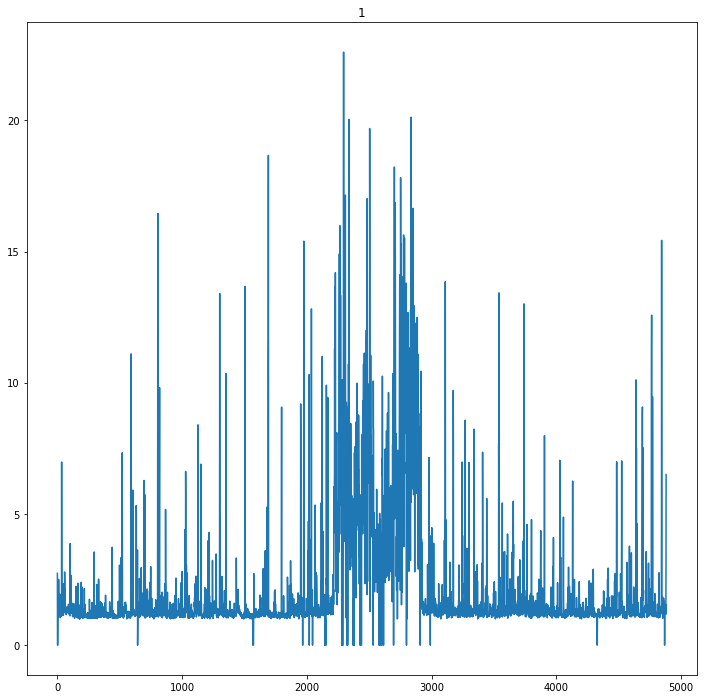

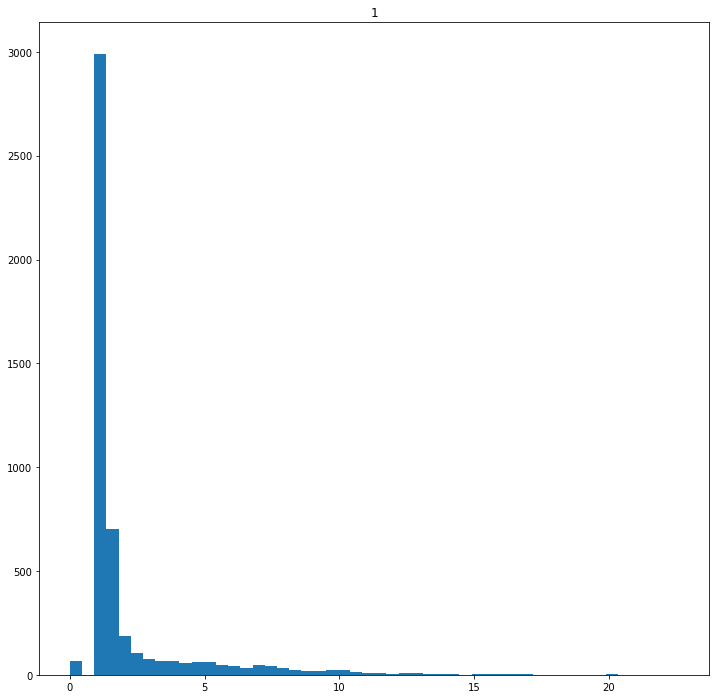

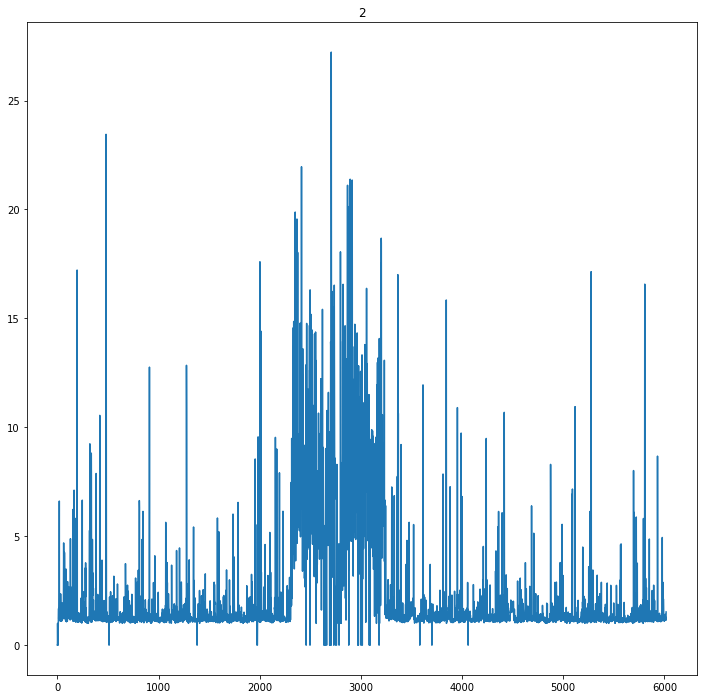

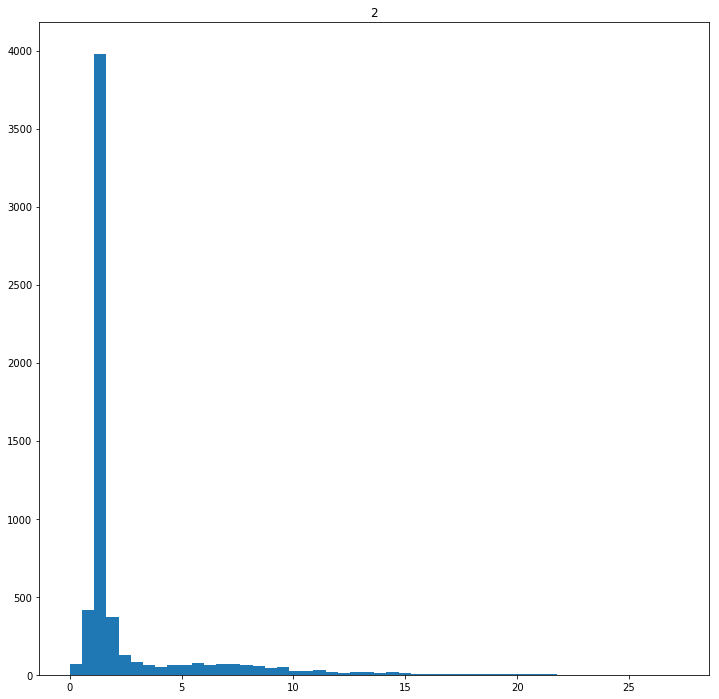

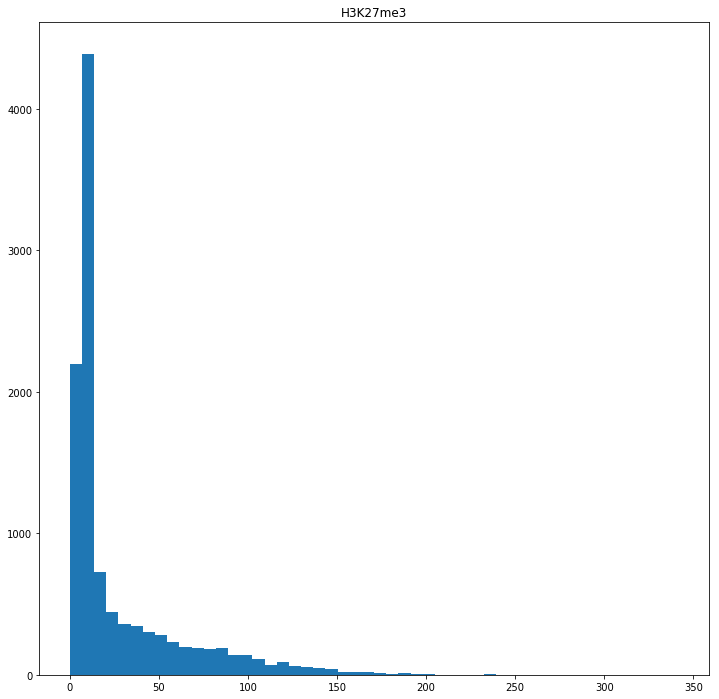

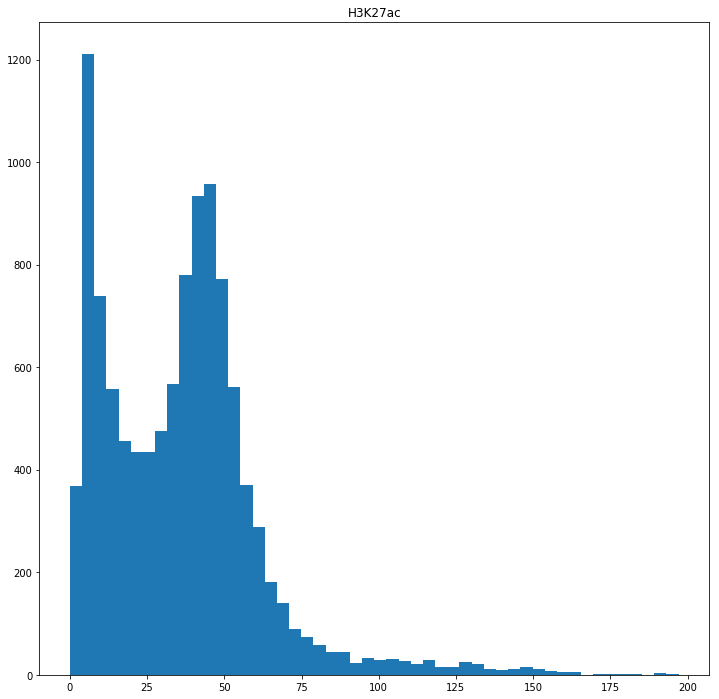

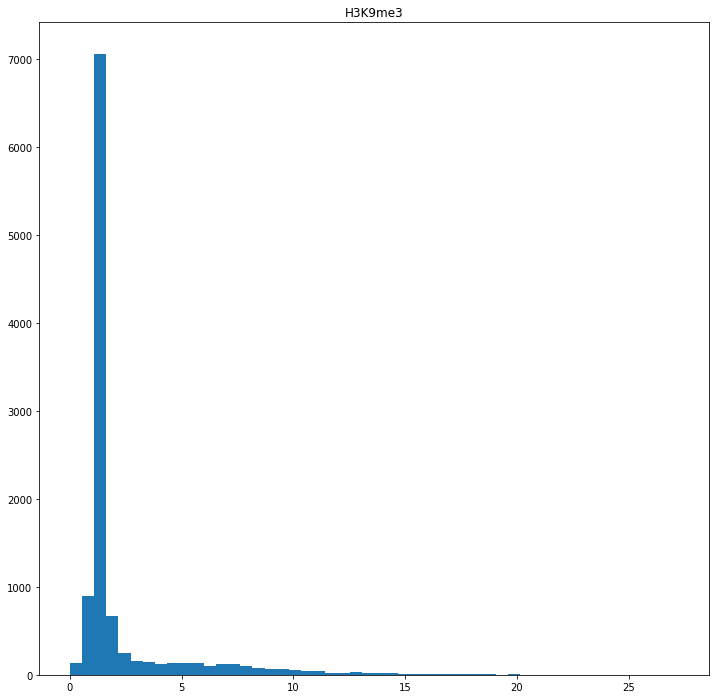

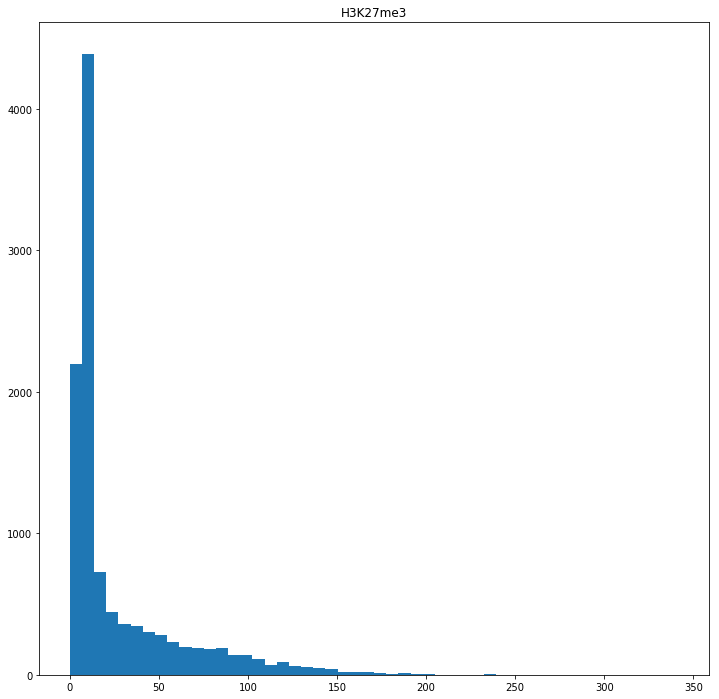

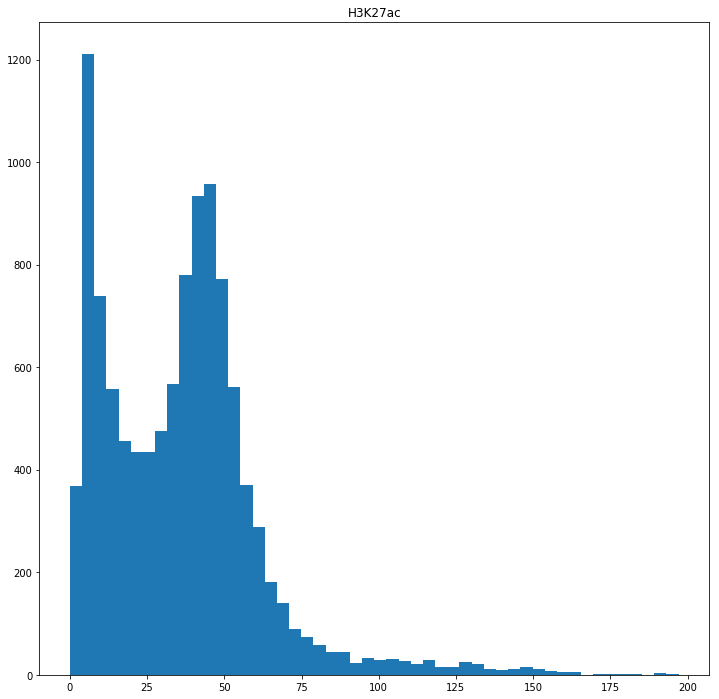

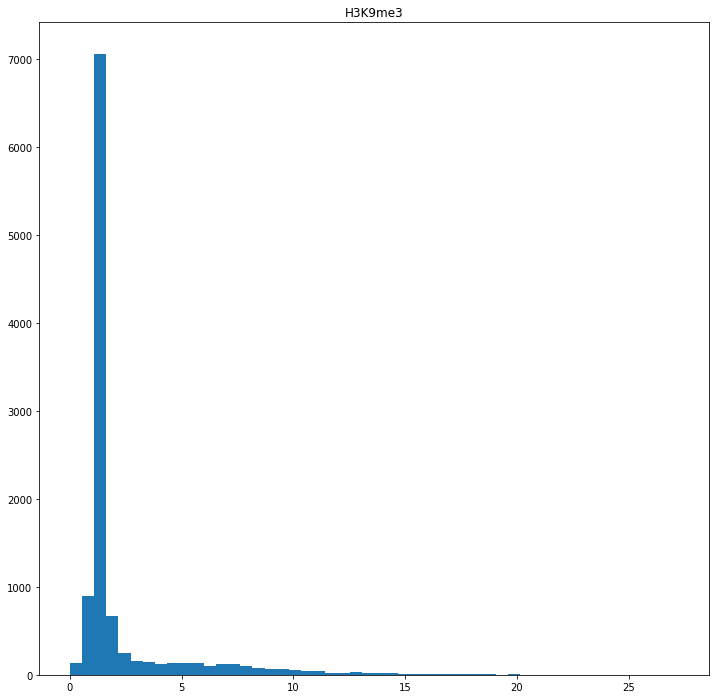

In [83]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (12,12)

hists = [[] for x in range(comp_num)]

print(comp_num)
count = 0
for df in dfs:
    count += 1
    plt.plot(df["H3K9me3"])
    plt.title(count)
    plt.show()
    plt.hist(df["H3K9me3"],bins=50)
    plt.title(count)
    plt.show()
    for x,column in enumerate(df[:comp_num]):
        #print(x)
        hists[x].extend(df[column].tolist())
    

for n,h in zip(names,hists):
    plt.hist(h,bins=50)
    plt.title(n)
    plt.show()
    
hists = [[] for x in range(comp_num)]    

for df in mean_dfs:
    #print(df)
    for x,column in enumerate(df[:comp_num]):
        #print(x)
        hists[x].extend(df[column].tolist())
    

for n,h in zip(names,hists):
    plt.hist(h,bins=50)
    plt.title(n)
    plt.show()




In [84]:
matplotlib.rcParams['figure.figsize'] = (10,10)

#chrom = 1

start = 0
end = 1000

#plt.plot(dfs[chrom][0:1000])
#plt.plot(mean_dfs[chrom][0:1000][:comp_num])
#plt.ylim(0,10)
#plt.show()

In [85]:
#here we will now implement a low-pass filter using fourier transform
"""
import numpy as np
import pandas as pd
import scipy

from scipy import signal



fft_fc = 0.1
fft_b = 0.08
fft_N = int(np.ceil((4 / fft_b)))
if not fft_N % 2: fft_N += 1
fft_n = np.arange(fft_N)


sinc_func = np.sinc(2 * fft_fc * (fft_n - (fft_N - 1) / 2.))
window = 0.42 - 0.5 * np.cos(2 * np.pi * fft_n / (fft_N - 1)) + 0.08 * np.cos(4 * np.pi * fft_n / (fft_N - 1))
sinc_func = sinc_func * window
sinc_func = sinc_func / np.sum(sinc_func)

s = list(df["Gro"])
fft_signal = np.convolve(s, sinc_func)
smooth_signal = list(df["Gro"].rolling(window=smooth,min_periods=1,center=True).mean())

xleft = 250
xright = 350

plt.plot(s[xleft:xright])
plt.plot(fft_signal[xleft:xright])
plt.plot(smooth_signal[xleft:xright])
#plt.legend()
plt.ylim(0,200)
plt.show()
"""

'\nimport numpy as np\nimport pandas as pd\nimport scipy\n\nfrom scipy import signal\n\n\n\nfft_fc = 0.1\nfft_b = 0.08\nfft_N = int(np.ceil((4 / fft_b)))\nif not fft_N % 2: fft_N += 1\nfft_n = np.arange(fft_N)\n\n\nsinc_func = np.sinc(2 * fft_fc * (fft_n - (fft_N - 1) / 2.))\nwindow = 0.42 - 0.5 * np.cos(2 * np.pi * fft_n / (fft_N - 1)) + 0.08 * np.cos(4 * np.pi * fft_n / (fft_N - 1))\nsinc_func = sinc_func * window\nsinc_func = sinc_func / np.sum(sinc_func)\n\ns = list(df["Gro"])\nfft_signal = np.convolve(s, sinc_func)\nsmooth_signal = list(df["Gro"].rolling(window=smooth,min_periods=1,center=True).mean())\n\nxleft = 250\nxright = 350\n\nplt.plot(s[xleft:xright])\nplt.plot(fft_signal[xleft:xright])\nplt.plot(smooth_signal[xleft:xright])\n#plt.legend()\nplt.ylim(0,200)\nplt.show()\n'

(10898, 3)
0         8.363361
1         0.000000
2         1.273857
3         2.250000
4         3.724138
5        38.103351
6        60.106011
7       102.380462
8        76.064768
9        92.239164
10      212.123865
11       98.776685
12      161.565294
13      141.486067
14       90.347231
15      124.410697
16      193.396874
17       42.194416
18       43.477417
19       40.460465
20       83.175793
21       55.169580
22       66.366492
23       32.964920
24      114.851833
25      107.067123
26       81.245332
27      117.347110
28       82.266410
29      121.764270
           ...    
5988     66.244406
5989    109.293365
5990     39.966099
5991     76.491043
5992     49.895050
5993     79.450168
5994     69.865668
5995     84.740894
5996     66.500377
5997     41.586761
5998     69.891824
5999     73.152109
6000     65.031208
6001     56.048339
6002     72.708533
6003     67.621075
6004     70.483142
6005     69.618781
6006     70.786066
6007     65.705436
6008     74.529487
6

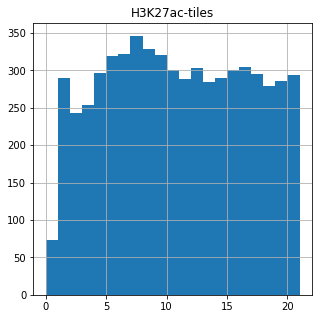

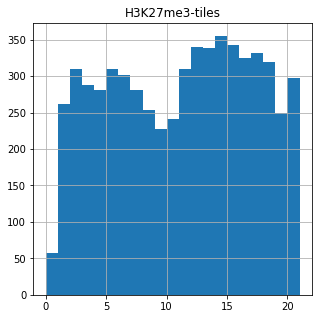

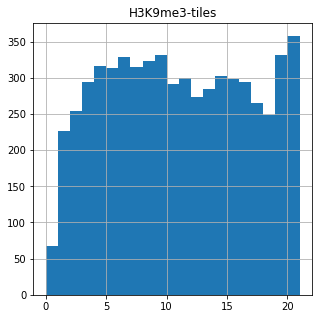

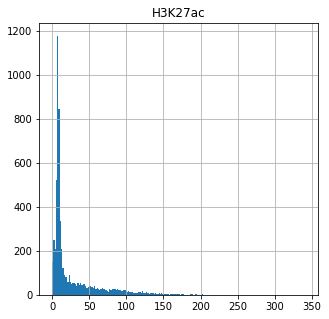

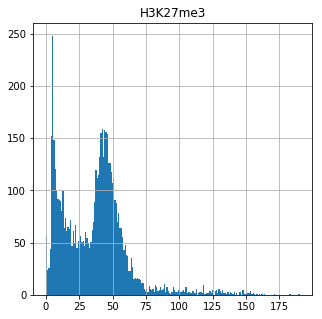

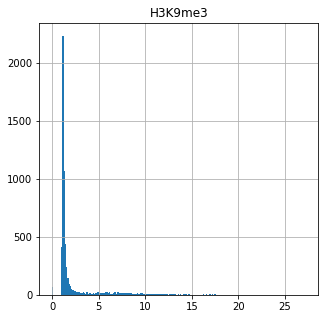

KC-small:10000-actual:10000-wgtiles
,H3K27ac,H3K27me3,H3K9me3
0.0,0.0,0.0,0.0
0.05,3.115138843106393,4.806219243963597,1.0671195864445915
0.1,5.120819157430778,6.177199042709544,1.0956832177267877
0.15000000000000002,6.21959363555054,8.50851293397794,1.116149271055268
0.2,6.895102625440825,11.451947146740686,1.1341943606239415
0.25,7.414474726842983,15.167450268110313,1.1517748578254685
0.30000000000000004,7.877528847891916,19.731357797431087,1.169454451214049
0.35000000000000003,8.304937118411639,24.60504406274402,1.1877169744241918
0.4,8.779476937404288,29.46161606838443,1.2071415206509843
0.45,9.311528658909022,33.59298652050688,1.2280708490300518
0.5,10.065862661957496,36.89473549236051,1.2521077559020362
0.55,11.353674965097182,39.47692495008921,1.2869213546872018
0.6000000000000001,13.546029961353419,41.815827383664995,1.3286384378453804
0.65,18.237350996421583,44.037577312776975,1.3916020483965217
0.7000000000000001,25.265587786036278,46.161358445229354,1.4931787610673424
0.75,3

In [86]:



#let's convert the fold changes over control to 'tiles. 'tiles aren't evenly spaced across range,
#instead each contains the same number of entries.

#this is quantiles, we want a more meaningful distribution though

quantiles = np.linspace(0,1,num=tiles,endpoint=True)
#print(quantiles)


signals = []

#first we just have to construct a big concatenated dataframe so we can call quantile on it.
#Then we just apply those quantiles to each individual chrom df.

concatdf = pd.concat(dfs)

#it would be nice if this worked but it doesn't so whatever.

print(concatdf.shape)
print((concatdf.sum(axis=1)))


#concatdf[(concatdf.sum(axis=1) != 0)]  
nozconcatdf = concatdf[concatdf.sum(axis=1) != 0]

#nozconcatdf = concatdf[(df.T != 0).any()]

print(nozconcatdf.shape)

wg_quantiles = nozconcatdf.quantile(quantiles)

print("quantiles")
print(wg_quantiles)

concatdf = []


for df in dfs:
    #df.replace(0, np.NaN,inplace=True)
    #for col in df:
        #col_smooth = col + '_smooth'
        #df[col_smooth] = df[col].rolling(window=smooth,min_periods=1,center=True).mean()
        #print(df[col])
        #print(df[col_smooth])
    
    #print(df)
    #print("q")
    #print(q)
    newcolumns = []
    for column in df.iloc[:,-comp_num:]:
        #print(df[column])
        #print(q[column])
        
        newcolumns.append([])
        for r in df[column]:
            place = wg_quantiles[column].searchsorted(r)#[0]
            newcolumns[-1].append(place)
        
    for index,column in enumerate(df.iloc[:,:comp_num]):
        df[column+"-tiles"] = pd.Series(newcolumns[index],dtype='int16')

#todo, more sophisticated tiling that uses a different dynamic range for each signal based on it's variance.

matplotlib.rcParams['figure.figsize'] = (5,5)

for col in dfs[0].iloc[:,-comp_num:]:
    df.hist(col,bins=range(tiles+1))
    plt.show()
    
for col in dfs[0].iloc[:,:comp_num]:
    df.hist(col,bins=200)
    plt.show()
    
#for col in dfs[1].iloc[:,-comp_num:]:
#    df.hist(col,bins=range(tiles+1))
#    plt.show()

#for x in range(quantiles):

#print(dfs)


#let's export those quantiles to a file
filename = "{0}-small:{1}-actual:{2}-{3}".format(celltype,small_resolution,resolution,"wgtiles")
wgt = open(filename,'w')

wg_quantiles.to_csv(wgt)


wgt.close()
print(filename)
! head -n 100 $filename


In [87]:
def mu(X,B):
    v = np.ones(X.shape[0])
    #print(v.shape)
    #print(X.shape)
    #print(B.shape)
    #print((X @ B).shape)
    old = v + X @ B
    #print(old.shape)
    #print(H.shape)
    return old


def logL(Y,X,B):
    u = mu(X,B)
    return np.nansum((Y - u)**2)
    

def grad(Y,X,B):
    u = mu(X,B)
    #v = np.ones(X.shape[0])
    return -2 * X.T @ (Y - u)

def hess(Y,X,B):
    """
    from scipy.sparse import coo_matrix
    from scipy.sparse import csr_matrix
    u = mu(X,B)
    num = (Y)
    denom = (u*u)
    frac = (num / denom)
    #print('frac')
    #print(frac.shape)
    #refrac = frac[:, np.newaxis]
    #print(refrac.shape)
    #print(X.shape)
    diag_i = []
    diag_j = []
    diag_v = []
    for x,entry in enumerate(frac):
        diag_i.append(x)
        diag_j.append(x)
        diag_v.append(entry)

    coo_diag = coo_matrix((diag_v, (diag_i, diag_j)), shape=(Y.shape[0], Y.shape[0]))
    #print(coo_diag)
    csr_diag = csr_matrix(coo_diag)    
    one = (csr_diag @ X)
    """
    return (-2*X.T @ X)
    
    #return -1 * (((Y*H*H) / (u*u) @ X).T @ X)

Loading: 2L vs 2R
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Size: 4883


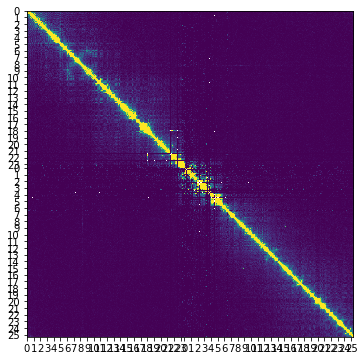

Sum Mean: 166080.691178557
Sum Std dev: 5604.027860437666
Nonzero Mean: 3055.6529449018367
Nonzero Std dev: 714.9505291402227
['H3K27ac-tiles', 'H3K27me3-tiles', 'H3K9me3-tiles']
sigs
[[2, 1, 17], [0, 0, 0], [0, 1, 0], [1, 1, 0], [1, 1, 1], [13, 6, 15], [16, 6, 10], [19, 6, 10], [14, 16, 13], [17, 12, 13]]



Ignoring 0 median bins
Ignoring 149 sum bins
Ignoring 308 zero bins
Ignoring 89 quant bins


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2413: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(a=a, axis=axis, keepdims=True)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Ignoring 252 zscore bins
Ignoring 570 total bins
len of dists
3209


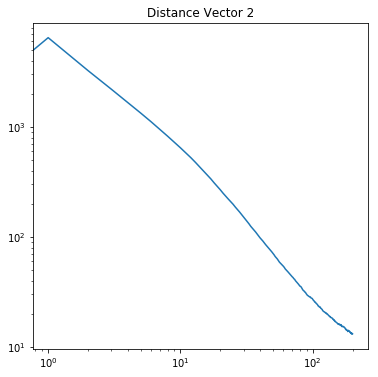

X (765442, 630)
Y (765442,)
B (630,)
H (765442,)


/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


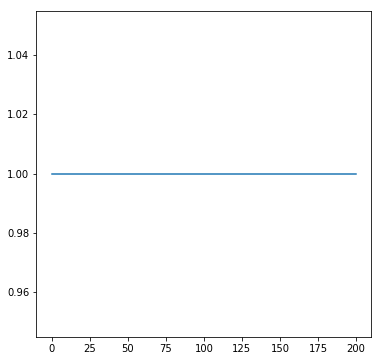

len of dists
3209


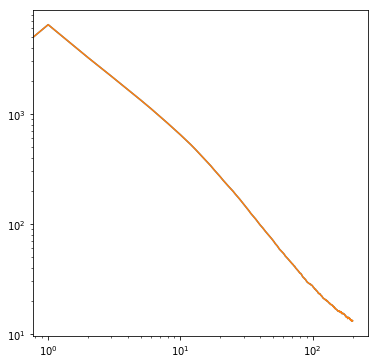

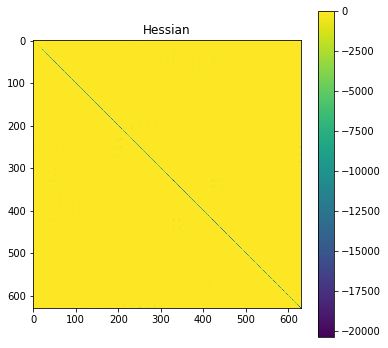

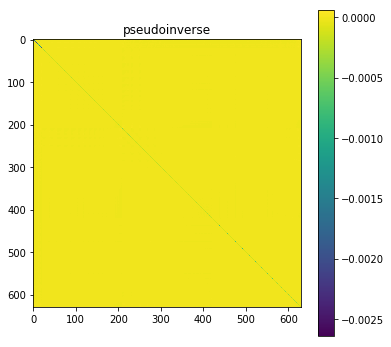

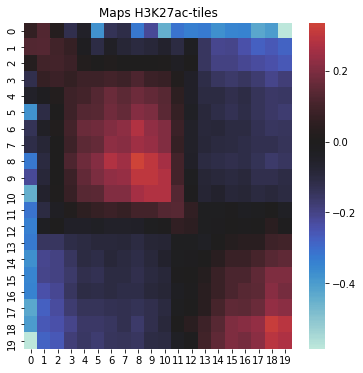

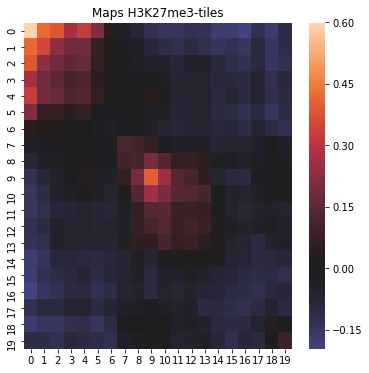

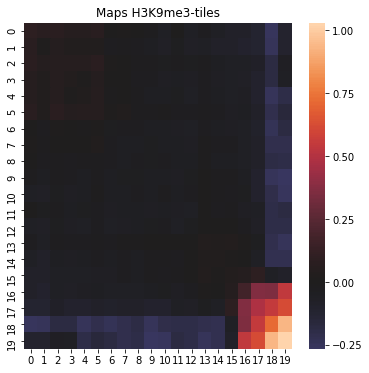

Log likelihood: 248602.21719522978
Last log likelihood: inf
Chromosome 2L Iteration 1 Improvement: inf
Pearson: (0)


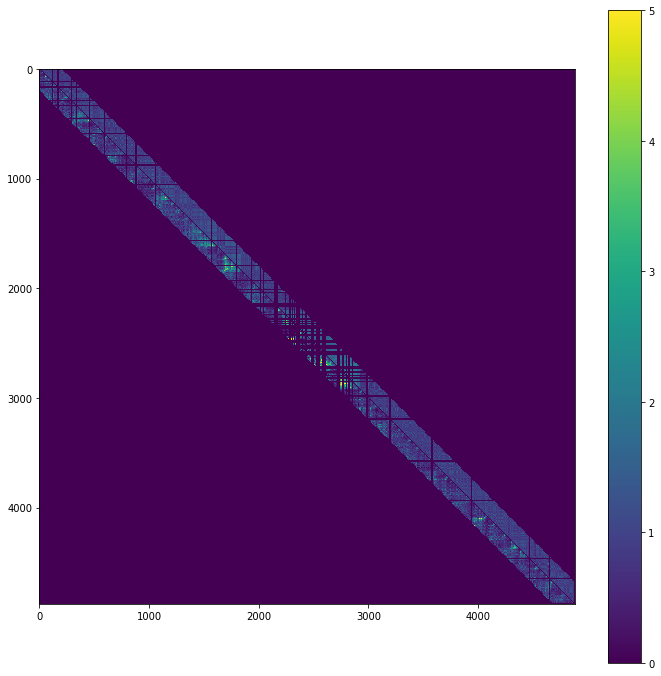

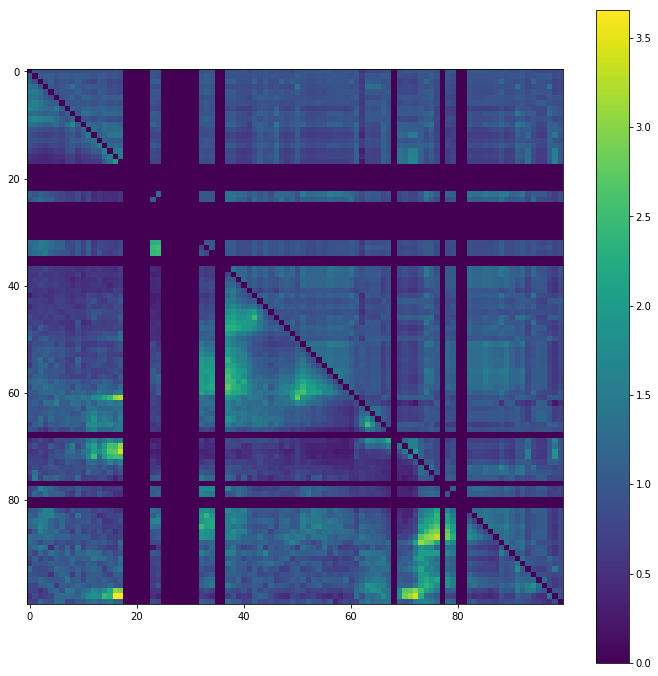

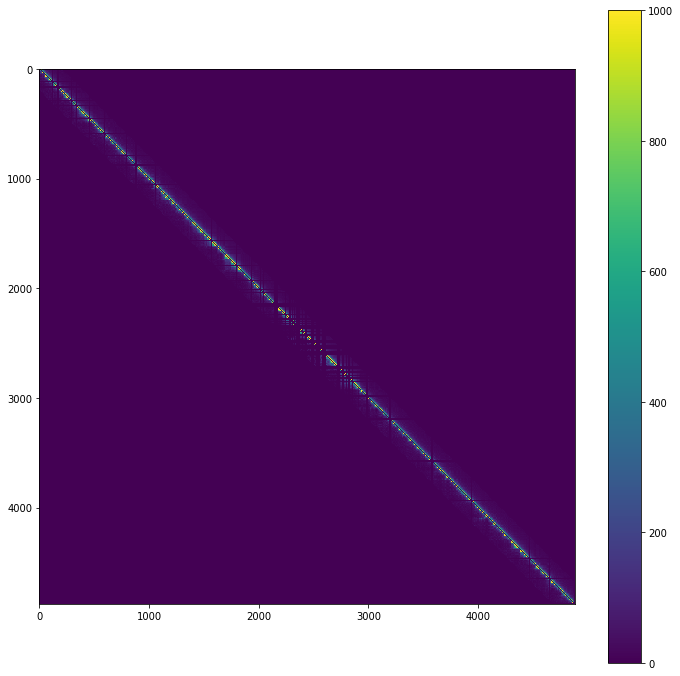

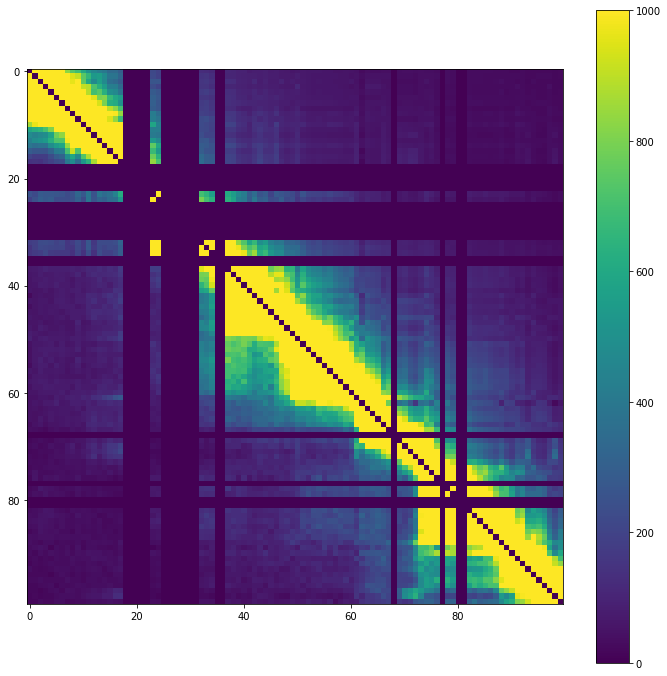

len of dists
3209


/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


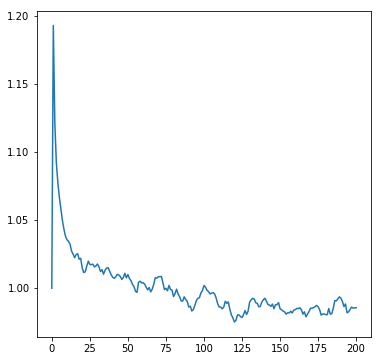

len of dists
3209


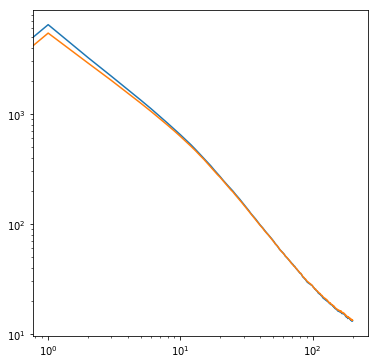

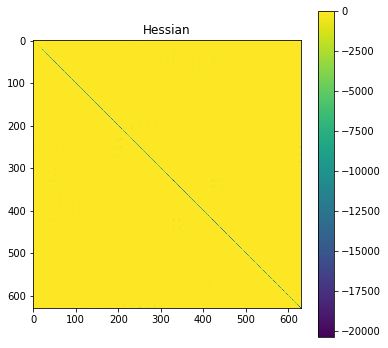

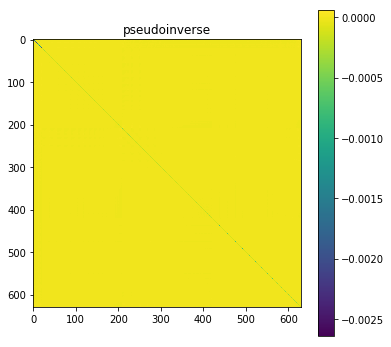

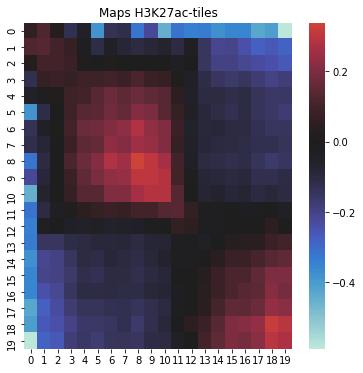

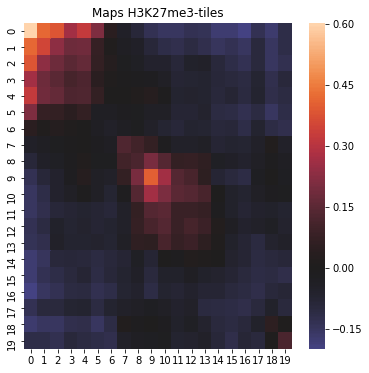

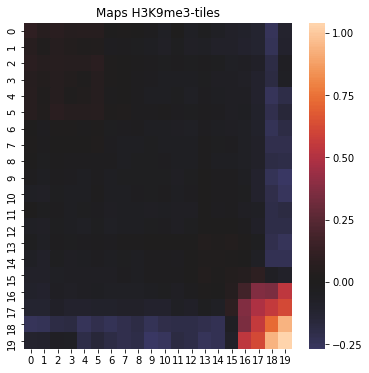

Log likelihood: 248243.00014400642
Last log likelihood: 248602.21719522978
Chromosome 2L Iteration 2 Improvement: 359.217051223357
Pearson: (0)


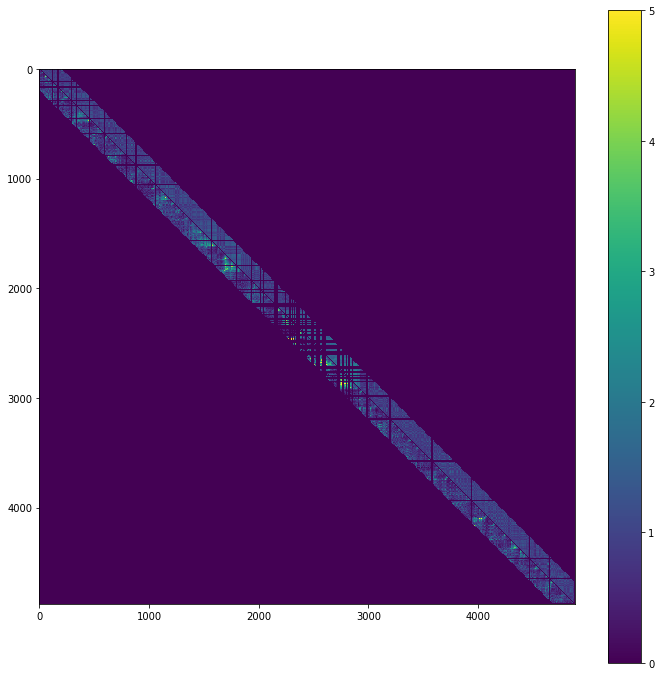

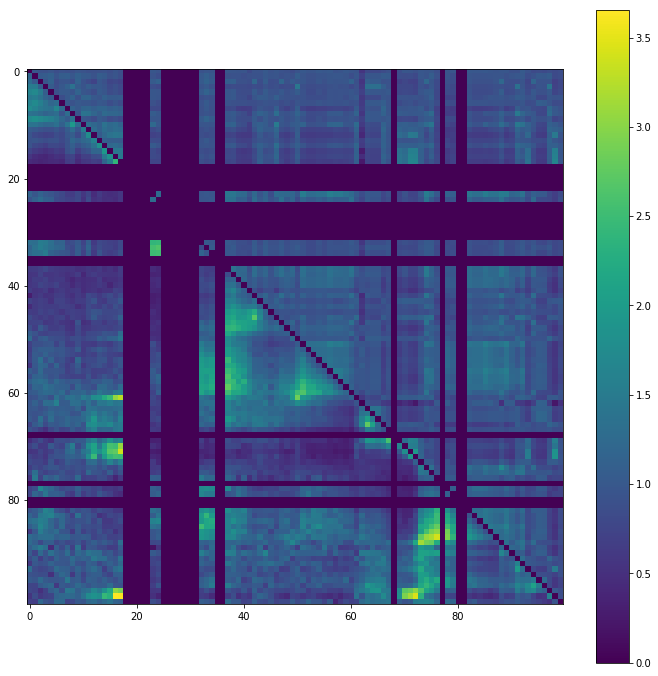

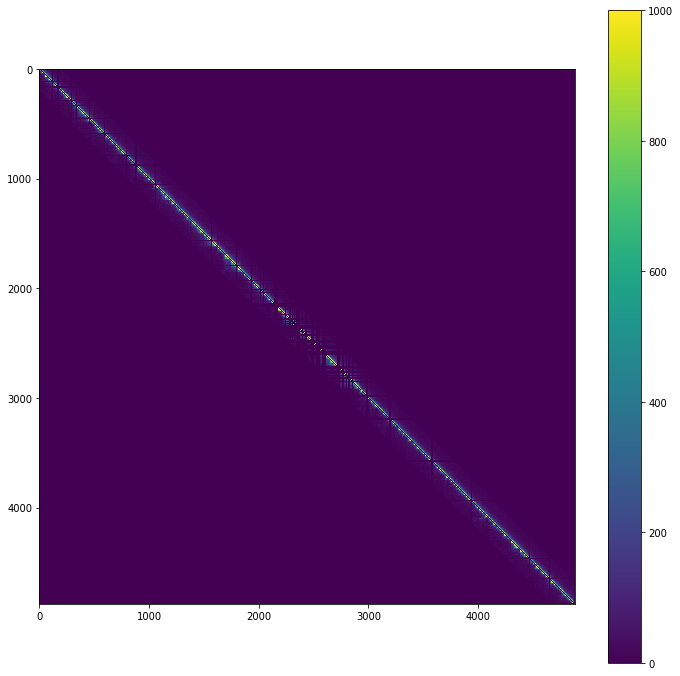

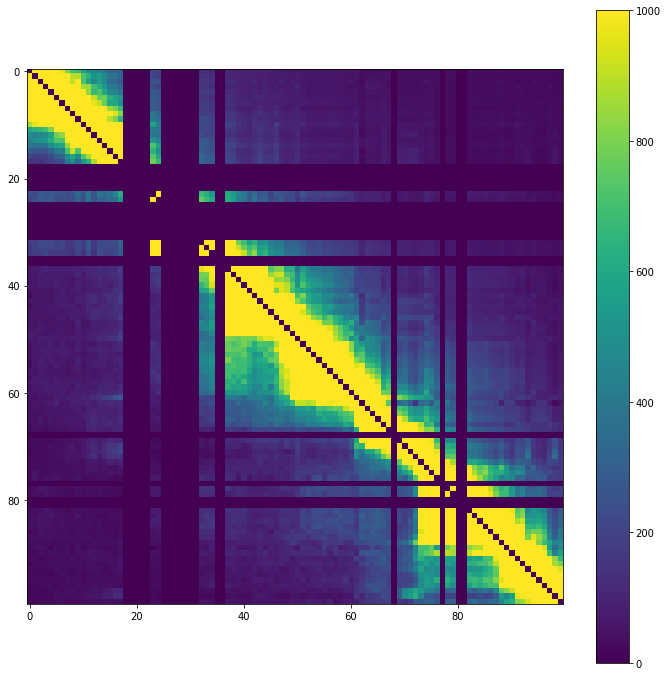

len of dists
3209
Loading: 3L vs 3R
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Size: 6022


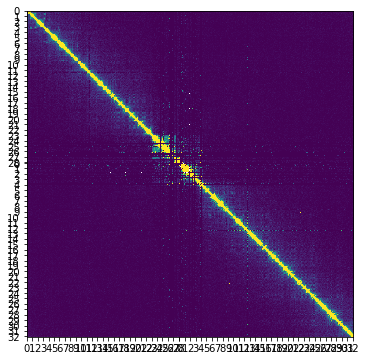

Sum Mean: 172471.60459054727
Sum Std dev: 5313.589881069324
Nonzero Mean: 3916.345181134655
Nonzero Std dev: 936.8324801261032
['H3K27ac-tiles', 'H3K27me3-tiles', 'H3K9me3-tiles']
sigs
[[0, 0, 0], [0, 0, 0], [1, 0, 1], [0, 1, 0], [0, 0, 0], [0, 1, 0], [0, 1, 0], [0, 1, 0], [1, 1, 1], [1, 1, 1]]



Ignoring 0 median bins
Ignoring 177 sum bins
Ignoring 397 zero bins
Ignoring 84 quant bins


/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:2413: RuntimeWarning: Mean of empty slice
  mns = np.nanmean(a=a, axis=axis, keepdims=True)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Ignoring 375 zscore bins
Ignoring 793 total bins
len of dists
3209


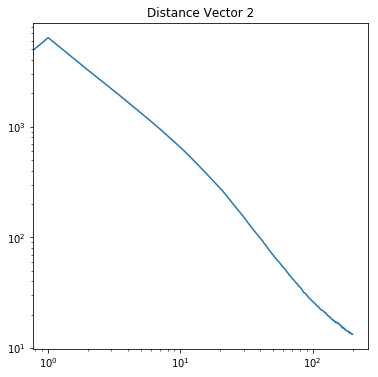

X (931168, 630)
Y (931168,)
B (630,)
H (931168,)


/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


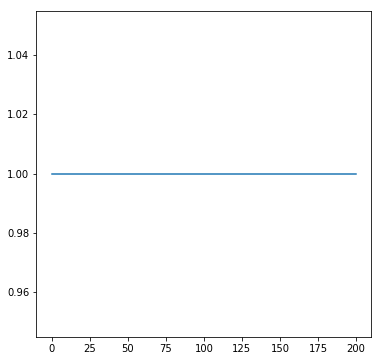

len of dists
3209


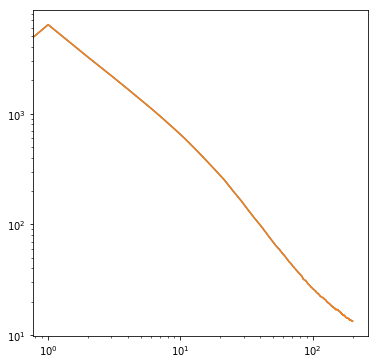

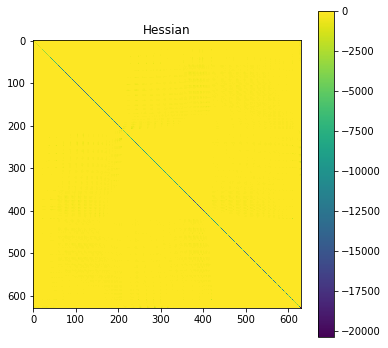

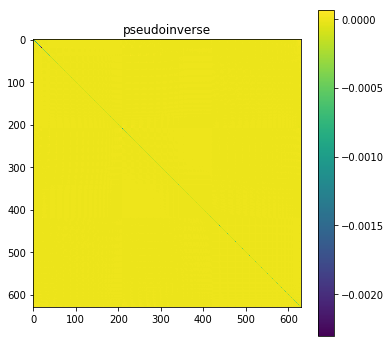

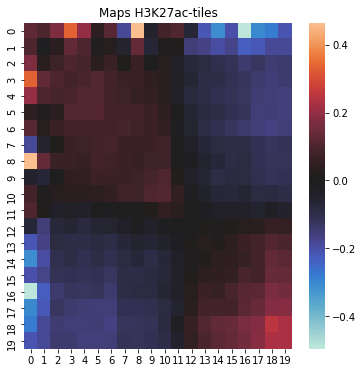

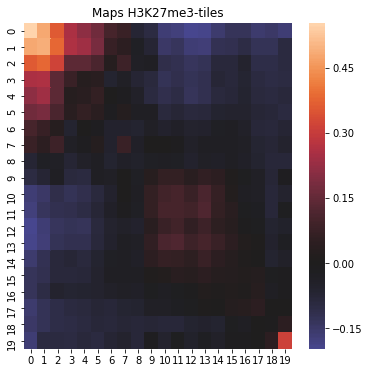

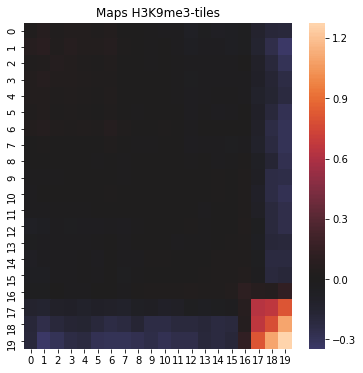

Log likelihood: 263415.9297331353
Last log likelihood: inf
Chromosome 3L Iteration 1 Improvement: inf
Pearson: (0)


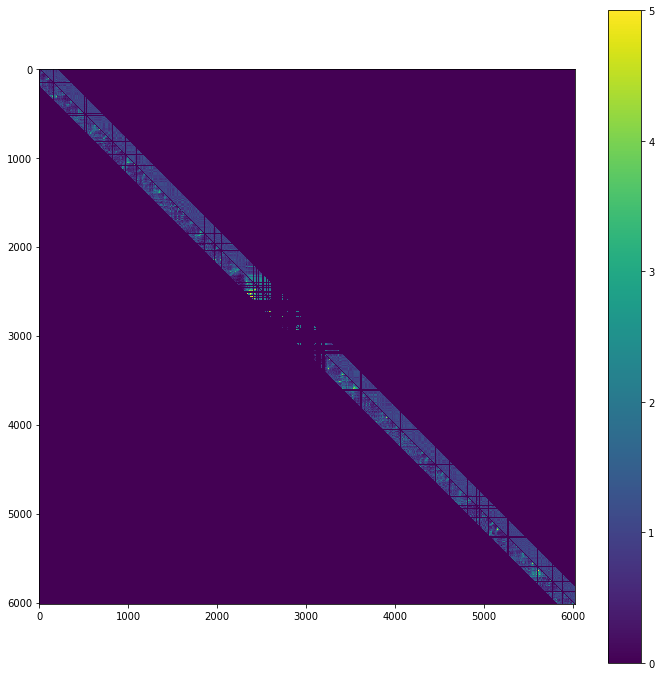

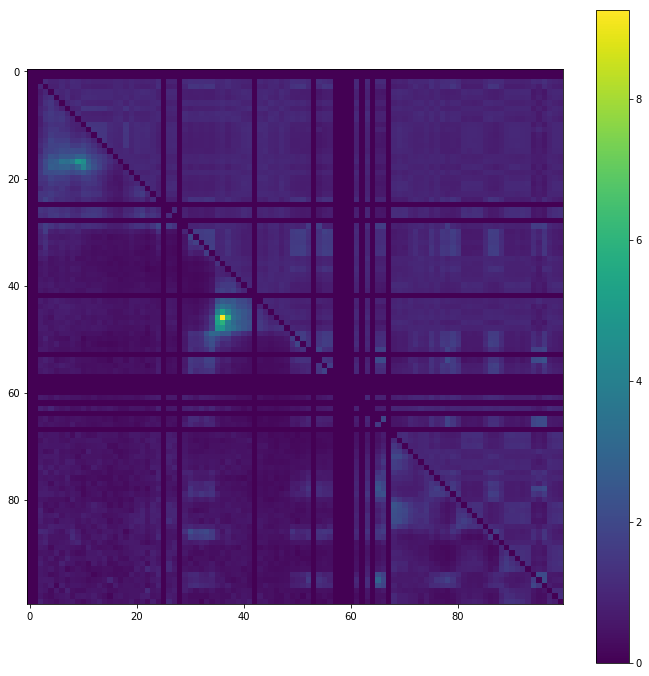

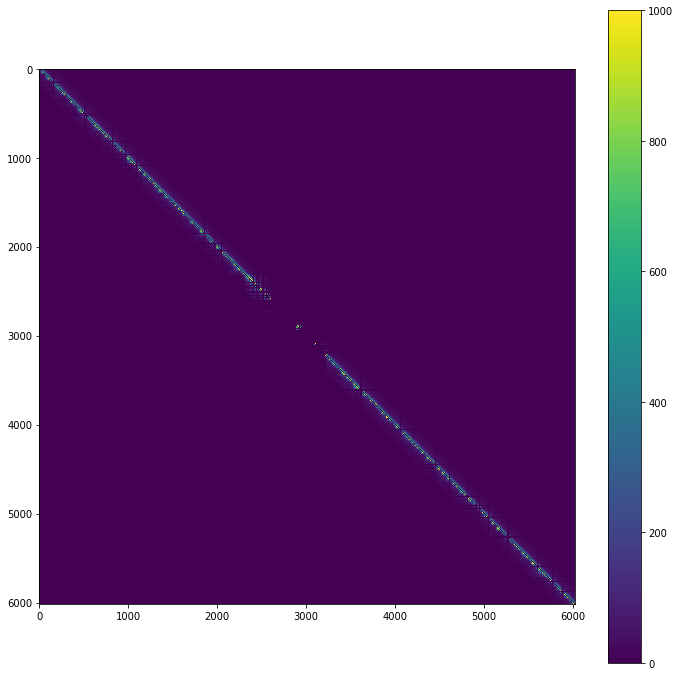

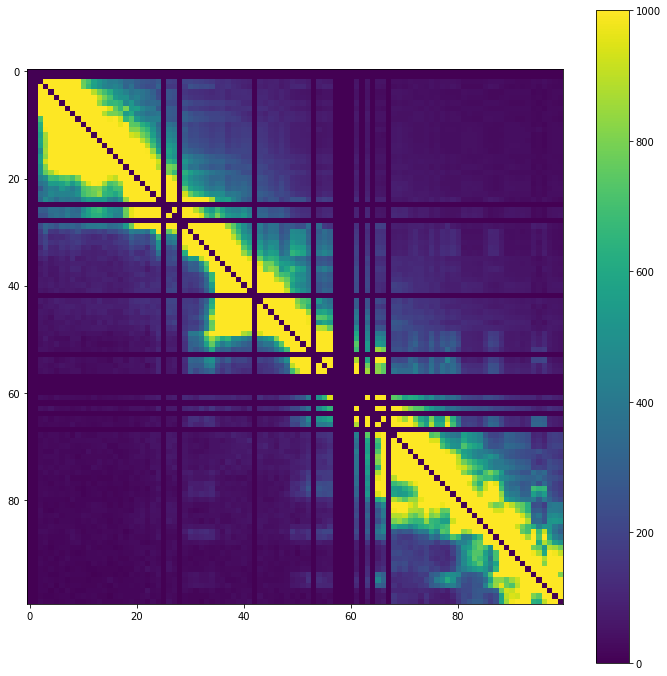

len of dists
3209


/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Zulu/mike/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


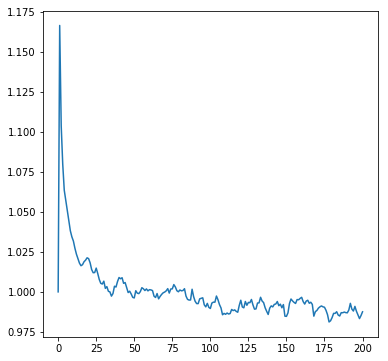

len of dists
3209


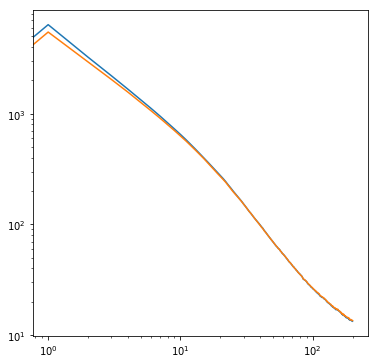

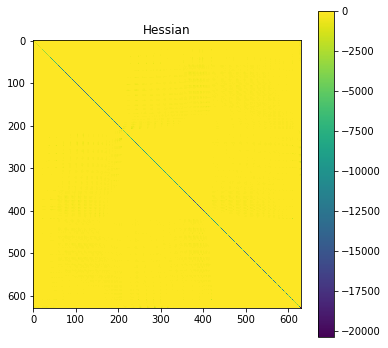

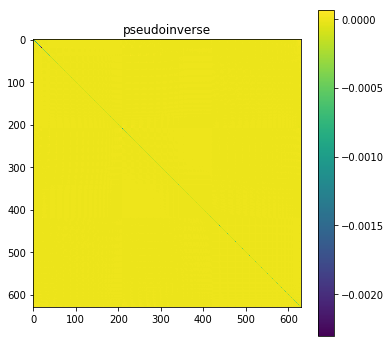

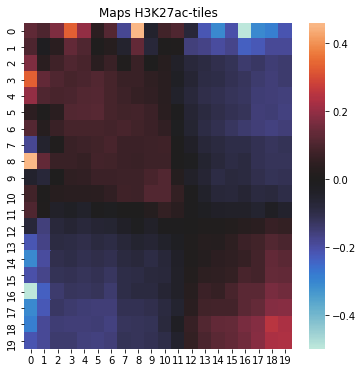

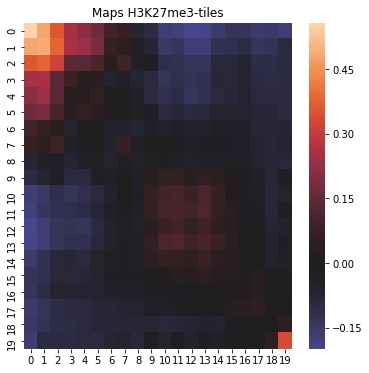

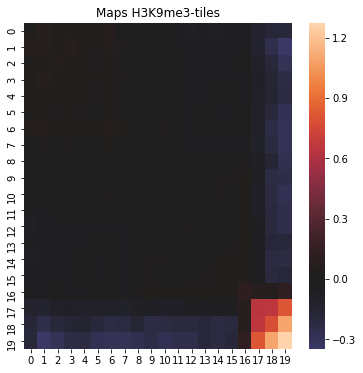

Log likelihood: 262941.0747128354
Last log likelihood: 263415.9297331353
Chromosome 3L Iteration 2 Improvement: 474.8550202998449
Pearson: (0)


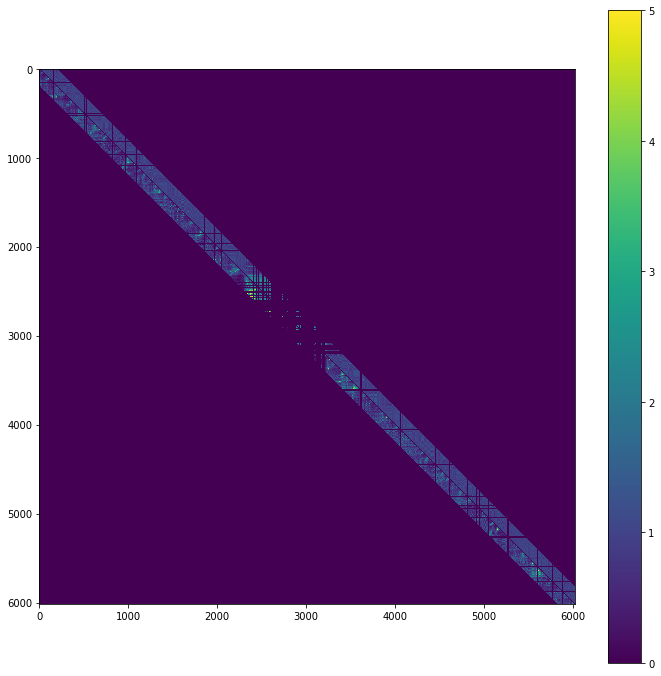

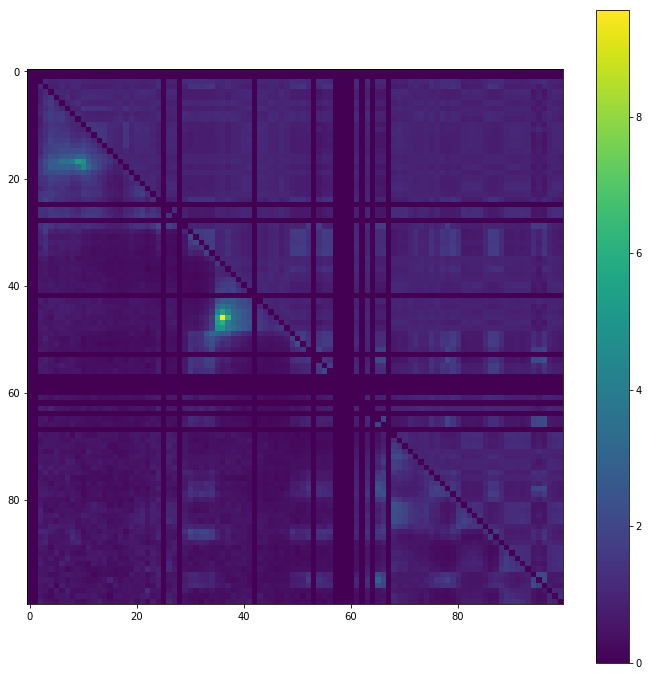

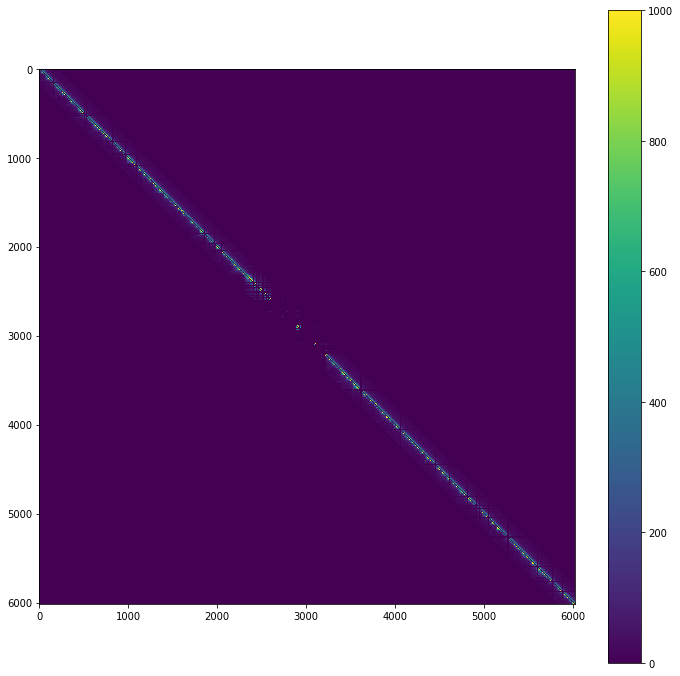

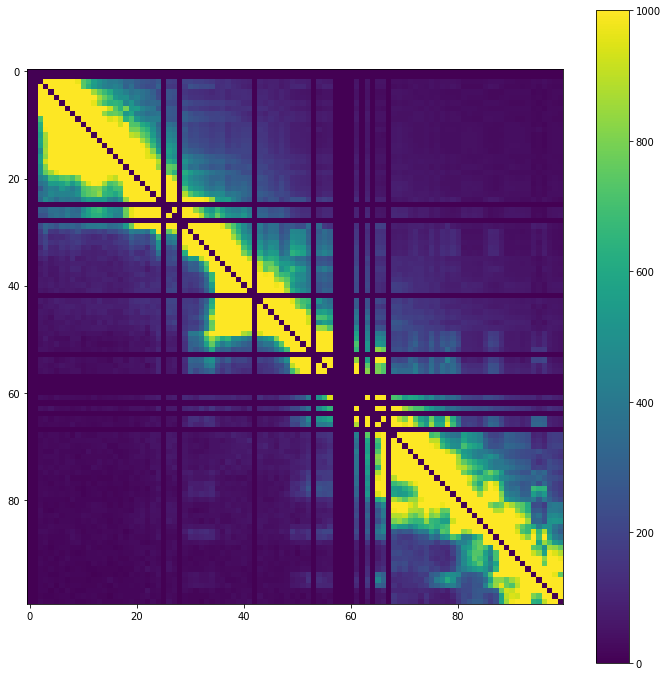

len of dists
3209


In [88]:
def MLE_ncomp(x,chrpairs=chrpairs,resolution=resolution,distance_min=distance_min,comp_num=comp_num,tiles=tiles,
                     distance_min_bins=distance_min_bins,distance_max=distance_max,distance_max_bins=distance_max_bins,chrnames=chrnames,D=D,M=M,
                     clims=clims,slims=slims,blims=blims,correction=correction,
                     chrsizebins=chrsizebins,distance_ranges=distance_ranges,ignoreplots=ignoreplots,
                     distance_indices=distance_indices,tolerance=tolerance,ignore_threshold=ignore_threshold,
                     max_iter=max_iter,hic_directory=hic_directory,hic_prefix=hic_prefix,
                     ignorebins=ignorebins,dfs=dfs,
                     medianhighstd=medianhighstd,medianlowstd=medianlowstd,highstd=highstd,lowstd=lowstd,
                      nz_low_threshold=nz_low_threshold,nz_high_threshold=nz_high_threshold):
    #now we will iterate through each chromosome.
    #for each chromosome we load in the matrix
    #initialize all of the parameters
    #for every bin i + distance_min/resolution >= j
    #compute gradient for distance
    #then compute gradient for bias
    #then compute c-score
    #then compute error

    import numpy as np
    import pandas as pd
    import math
    import matplotlib.pyplot as plt
    from scipy.sparse import coo_matrix
    from scipy.sparse import csr_matrix
    import seaborn as sns
    from scipy import stats
    
    pair = chrpairs[x]
    chrom1 = chrnames[pair[0]]
    chrom2 = chrnames[pair[1]]
    #sizebins = chrsizebins[chrindex]
    print("Loading: {0} vs {1}".format(chrom1,chrom2))
    #print("Size: {0}".format(sizebins))
    
    interactions1 = open(hic_directory+hic_prefix+"arm_"+chrom1+"_"+"arm_"+chrom1+"_"+str(resolution)+".txt",'r')
    interactions12 = open(hic_directory+hic_prefix+"arm_"+chrom1+"_"+"arm_"+chrom2+"_"+str(resolution)+".txt",'r')
    interactions2 = open(hic_directory+hic_prefix+"arm_"+chrom2+"_"+"arm_"+chrom2+"_"+str(resolution)+".txt",'r')
    
    pairsize = chrsizebins[pair[0]] + chrsizebins[pair[1]]
    sizebins=pairsize
    
    matrix = np.zeros((pairsize,pairsize))
    print(matrix)
    print("Size: {0}".format(pairsize))
    
    #let's make each chromosome, normalize it, then add it to the big one.
    for line in interactions1:
        li = line.split()
        left = int(li[0])//resolution
        right = int(li[1])//resolution
        KRscore = float(li[2])
        matrix[left][right] = KRscore
        matrix[right][left] = KRscore
        
    for line in interactions2:
        li = line.split()
        left = int(li[0])//resolution + chrsizebins[pair[0]]
        right = int(li[1])//resolution + chrsizebins[pair[0]]
        KRscore = float(li[2])
        matrix[left][right] = KRscore
        matrix[right][left] = KRscore    
        
    for line in interactions12:
        li = line.split()
        left = int(li[0])//resolution
        right = int(li[1])//resolution + chrsizebins[pair[0]]
        KRscore = float(li[2])
        matrix[left][right] = KRscore
        matrix[right][left] = KRscore        
        
        
    interactions1.close()
    interactions12.close()
    interactions2.close()
        
        
    #plt.imshow(matrix)
    #plt.show()
    mbmapping = int(1000000/resolution)
    ticklocs = [x for x in range(0,pairsize,mbmapping)]
    ticklabels = [x for x in range(len(ticklocs))]    
    
    #plt.imshow(matrix,vmax=100)
    #plt.title("Chromosome {0} Original".format(chrom1))
    
    #plt.xticks(ticklocs,labels=ticklabels)
    #plt.yticks(ticklocs,labels=ticklabels)
    #plt.savefig("highqual-2L+2R.svg",dpi=1200,format="svg")    
    #plt.show()

    altticklocs1 = [x for x in range(0,chrsizebins[pair[0]],mbmapping)]
    altticklabels1 = [x for x in range(len(altticklocs1))]
    altticklocs2 = [x for x in range(chrsizebins[pair[0]],chrsizebins[pair[0]]+chrsizebins[pair[1]],mbmapping)]
    altticklabels2 = [x for x in range(len(altticklocs2))]
    altticklocs = altticklocs1+altticklocs2
    altticklabels = altticklabels1+altticklabels2
    

    plt.imshow(matrix,vmax=100)
    #plt.title("Chromosome {0} Original".format(chrom1))
    
    plt.xticks(altticklocs,labels=altticklabels)
    plt.yticks(altticklocs,labels=altticklabels)
    #plt.savefig("highqual-2L+2R-alt-ticks.svg",dpi=1200,format="svg")
    plt.show()
    
    matrix = np.nan_to_num(matrix)
    
    if "medians" in correction:
        medians = np.median(matrix,axis=0)
    
        median_mean = np.mean(medians[medians != 0])
        median_stddev = np.std(medians[medians != 0])
        
        print("Median Mean: {0}".format(median_mean))
        print("Median Std dev: {0}".format(median_stddev))
        high_line_data = np.array([median_mean+(median_stddev*medianhighstd) for i in range(len(medians))])
        low_line_data = np.array([median_mean-(median_stddev*medianlowstd) for i in range(len(medians))])
        if ignoreplots:
            plt.plot(medians)
            plt.plot(high_line_data, 'r--')
            plt.plot(low_line_data, 'r--')
            plt.show()
        medianignorebins = [(median_mean+(median_stddev*medianhighstd) < c) 
                      or median_mean-(median_stddev*medianlowstd) > c for c in medians]
    else:
        medianignorebins = [False for c in range(len(matrix[0]))]        

    
    
    if "sums" in correction:
        sums = np.sum(matrix,axis=0) + np.sum(matrix,axis=1)
        sum_mean = np.mean(sums[sums != 0])
        sum_stddev = np.std(sums[sums != 0])
        print("Sum Mean: {0}".format(sum_mean))
        print("Sum Std dev: {0}".format(sum_stddev))
        high_line_data = np.array([sum_mean+(sum_stddev*highstd) for i in range(len(sums))])
        low_line_data = np.array([sum_mean-(sum_stddev*lowstd) for i in range(len(sums))])
        sumymin = sum_mean+(sum_stddev*highstd*5)
        sumymax = sum_mean-(sum_stddev*lowstd*5)
        
        if ignoreplots:
            plt.plot(sums)
            plt.ylim(sumymin,sumymax)
            plt.plot(high_line_data, 'r--')
            plt.plot(low_line_data, 'r--')
            plt.show()
        sumignorebins = [(sum_mean+(sum_stddev*highstd) < c) or sum_mean-(sum_stddev*lowstd) > c for c in sums]
    else:
        sumignorebins = [False for c in range(len(matrix[0]))]
        
    
    if "nonzero" in correction:
        nonzerocounts = np.count_nonzero(matrix,axis=0)
        nonzero_mean = np.mean(nonzerocounts[nonzerocounts != 0])
        nonzero_stddev = np.std(nonzerocounts[nonzerocounts != 0])
        print("Nonzero Mean: {0}".format(nonzero_mean))
        print("Nonzero Std dev: {0}".format(nonzero_stddev))
        nonzeroignorebins = [(nonzero_mean+(nonzero_stddev*nz_high_threshold) < c) or
                      (nonzero_mean-(nonzero_stddev*nz_low_threshold) > c) for c in nonzerocounts]    
        if ignoreplots:
            plt.plot(nonzerocounts)
            high_line_data = np.array([nonzero_mean+(nonzero_stddev*nz_high_threshold) for i in range(len(nonzerocounts))])
            low_line_data = np.array([nonzero_mean-(nonzero_stddev*nz_low_threshold) for i in range(len(nonzerocounts))])   
            plt.plot(high_line_data, 'r--')
            plt.plot(low_line_data, 'r--')
            plt.show()        
    else:
        nonzeroignorebins = [False for c in range(len(matrix[0]))]  
        
    df = dfs[x]
    
    sigs = []
    
    #load in sigs so we can remove 0 quantiles
    signames = df.columns[-comp_num:].tolist()
    print(signames)
    for index, row in df.iloc[:,-comp_num:].iterrows():
        try:
            sigs.append([int(r) for r in row][-comp_num:])
        except ValueError:
            print("NaN")
            print(index)
            print(row)        
    print('sigs')
    #print(sigs)
    
    print(sigs[:10])
    #here we reverse sigs
    #signames.reverse()
    #holdsigs = [s.reverse() for s in sigs]
    #sigs = holdsigs
    #for s in sigs:
    #    s.reverse()
    #print(signames)
    #print(sigs[:10])
    
    
    if "quant" in correction:
        quantignorebins = [False for c in range(len(matrix[0]))]
        for n in range(len(signames)):
            print()
            for x in range(len(sigs)):
                if sigs[x][n] == 0:
                    quantignorebins[x] = True
    else:
        quantignorebins = [False for c in range(len(matrix[0]))]      
    
    ignorebins = [w | x | y | z for (w,x,y,z) in zip(medianignorebins, sumignorebins, nonzeroignorebins,quantignorebins)]
    print("Ignoring {0} median bins".format(sum(medianignorebins)))
    print("Ignoring {0} sum bins".format(sum(sumignorebins)))
    print("Ignoring {0} zero bins".format(sum(nonzeroignorebins)))
    print("Ignoring {0} quant bins".format(sum(quantignorebins)))

    #now we need to ignore z-norm outliers
    #first we set ignore rows and columns to nan
    #so they will be omitted by zscore operation
    nan_ignore_matrix = np.copy(matrix)
    nan_ignore_matrix[ignorebins,:] = np.nan
    nan_ignore_matrix[:,ignorebins] = np.nan
    
    #print(nan_ignore_matrix[0:10,0:10])
    
    
    zscoreignorebins = np.zeros(sizebins, dtype=bool)
    for d in range(sizebins):
        zscores = stats.zscore(np.diag(nan_ignore_matrix,d),nan_policy='omit')
        for e,z in enumerate(zscores):
            if z == np.nan:
                zscoreignorebins[e] = False
                zscoreignorebins[e+d] = False
            elif z > zscore_threshold:
                #make both row and column false
                zscoreignorebins[e] = True
                zscoreignorebins[e+d] = True
                
    #now we remove these bad bins
    print("Ignoring {0} zscore bins".format(sum(zscoreignorebins)))
    ignorebins = [x | y for (x,y) in zip(ignorebins,zscoreignorebins)]
    
    print("Ignoring {0} total bins".format(sum(ignorebins)))
    #now matrix is our entirely unnormalized matrix
    #initialize our variables:
    dists = list(D[:sizebins])
    maps = list(M[:])
    print("len of dists")
    print(len(dists))
    

    #for col in df.columns[:comp_num]:
    #    comps.append(list(df[col][:sizebins]))
    
    

    #for x in range(len(comps)):
    #    for y in range(len(comps[x])):
    #        if comps[x][y] < 0:
    #            comps[x][y] = 0
    #print(len(sigs[0]))
    #print(len(maps))
    
    #here we want to set True on ignore flag for any bins outside sig coverage
    #print("sigs")
    #print(len(sigs))
    #print("ignore")
    #print(len(ignorebins))

    if len(sigs) < len(ignorebins):
        for x in range(len(sigs),len(ignorebins)):
            #print(x)
            ignorebins[x] = True
    
    LLL = np.Inf
    count = 0
    error = 100000
    #d_error = 100
    #b_error = 100
    #c_error = 100
    
    #OK now let's define all our matrices:
    #to get y we need to compress to remove ignore bins, flatten,
    igno = np.where(ignorebins)[0]
    #print(igno)
    matrixdf = pd.DataFrame(matrix)
    #print("matrix")
    #print(matrixdf.shape)
    #matrixdf.drop(igno,axis=0,inplace=True)
    #matrixdf.drop(igno,axis=1,inplace=True)
    #plt.imshow(matrixdf,vmin=0,vmax=100)
    #plt.show()
    #print(ignorebins)
    #matrixdf.iloc[:,igno] = 0
    #matrixdf.iloc[igno,:] = 0    
    matrixdf.iloc[:,ignorebins] = np.nan
    matrixdf.iloc[ignorebins,:] = np.nan
    #plt.imshow(matrixdf,vmin=0,vmax=100)
    #plt.show()
    #now nan out the lower triangle:
    matrixdf = matrixdf.where(np.tril(np.triu(np.ones(matrixdf.shape),k=1+distance_min_bins),k=min(distance_max_bins,matrixdf.shape[0])).astype(np.bool))
    matrixdf = matrixdf.stack().reset_index()
    matrixdf.columns = ['i','j','v']
    #print(matrixdf)
    Y = matrixdf['v']
    #Y = np.reshape(np.array(Y),(Y.shape[0],1))
    
 
    #y = matrixdf.to_numpy.flatten()#observed values vector
    #B is now the learned coefficients. Basically the flattened maps. Constructed by comparing sigs to y
    #tiles * tiles * comp_num
    ttiles = tiles-1
    trisize = ((ttiles*(ttiles+1))//2)
    #print("sizes")
    #print(trisize)
    bsize = trisize*comp_num
    #print(bsize)
    B = np.zeros(bsize)
    #B[0] = 1
    #B = np.reshape(B,(bsize,1))
    
    #print('ysize')
    #print(Y.shape)
    #print('bsize')
    #print(bsize)    
    
    
    #lastly we need to define H. This is the expected value based on distance for every value.
    #we can initialize it as 0's and then learn it first.
    H = np.zeros(Y.shape[0])
    #H = np.reshape(H,(Y.shape[0],1))
    #to learn H you learn the full matrix, then you average every distance together
    H_dists = matrixdf['j'] - matrixdf['i']
    #print(H_dists)
    #print(H_dists)
    #print(H_dists[H_dists==1])
    Hadj = np.ones(len(dists))
    Hadj_exp = np.ones(Y.shape[0])
    
    #X is a CSR sparse matrix with each column corresponding to a sig-tile and each row a matrix bin.
    #X dimensions are y x B
    #once we have flattened y we can fill in each element in X. Should be 4 1's per row 
    #we construct by iterating over matrixdf, grabbing the appropriate sigs and adding that to a COO or DOK matrix.
    xijdic = {}
    for x in range(comp_num):
        for i in range(ttiles):
            for j in range(i,ttiles):
                y = trisize*x + np.sum(np.array(range(-1*i,0))+ttiles+1) + j-i
                xijdic[y] = [x,i,j]
    
    ii = []
    jj = []
    dd = []
    for index, row in matrixdf.iterrows():
        #first start with 1 in every row for B_0:
        #ii.append(index)
        #jj.append(0)
        #dd.append(1)
        #print(row)
        #print(row['i'])
        #print(row['j'])
        sigs_i = sigs[int(row['i'])]
        sigs_j = sigs[int(row['j'])]
        for x, (i,j) in enumerate(zip(sigs_i,sigs_j)):
            #here x is comp num, i is first quantile, j is second quantile
            #formula to get correct bin therefore is (1+tiles*tiles*x + tiles*i + j)
            if i > j:
                h = i
                i = j
                j = h
            ii.append(index)
            i = i-1
            j = j-1
            #jj.append(1+tiles*tiles*x + tiles*i + j)
            y = trisize*x + np.sum(np.array(range(-1*i,0))+ttiles+1) + j-i
            jj.append(y)
            dd.append(1)
        
        
    #print(xijdic)
    coo = coo_matrix((dd, (ii, jj)), shape=(Y.shape[0], bsize))
    #print(coo_matrix)
    X = csr_matrix(coo)
    #print('X')
    #print(np.sum(X,axis=0))
    #print(np.sum(X,axis=1))
    
    for d in range(1, len(dists)):
        #d_indices = np.where(H_dists == d)
        dmean = np.mean(Y[H_dists == d])
        H[H_dists == d] = dmean
        dists[d] = dmean

    #print(dists)
    #H = H1

    plt.plot(dists)
    plt.yscale('log')
    plt.xscale('log')
    plt.title("Distance Vector {0}".format(x))
    plt.show()
    

    
    #let's compute the distance parameter
    #print(len(sigs))
    #print(len(ignorebins))
    #print(ignorebins[-10:])
    
    print("X {0}".format(X.shape))
    print("Y {0}".format(Y.shape))
    print("B {0}".format(B.shape))
    print("H {0}".format(H.shape))
    


    #plt.plot(dists)
    #plt.title("Distance Vector {0}".format(chrindex))
    #plt.show()
    #now we will begin iterating
    while error > tolerance and count < max_iter:
        #while count < max_iter:
        count += 1
        
        #olddists = np.copy(dists)
        #for d in range(len(dists)):
        #    dists[d] = ncomp_distance_update(d,matrix,sizebins,dists,sigs,maps,distance_ranges,ignorebins)
        #olddists = dists
        #plt.plot(olddists)
        #XB = (X @ B)
        #print(XB.shape)
        #print(XB)
        #H1 = Y/(X @ B)
        #print(H1)
        for d in range(1,len(dists)):
            #d_indices = H_dists[H_dists==d]
            XBmean = np.mean(mu(X,B)[H_dists==d])
            Hadj_exp[H_dists==d] = XBmean
            Hadj[d] = XBmean
        
        
        plt.plot(Hadj)
        plt.show()
        #now divide by H
        Yh = np.nan_to_num(Y/(H / Hadj_exp))
        #print(len(H))
        #print(len(Hadj_exp))
        #print(len(Y))
        #print(len(Yh))
        #print(Yh)
        print("len of dists")
        print(len(dists))
        plt.plot(dists)
        plt.plot(dists / Hadj)
        plt.yscale('log')
        plt.xscale('log')
        plt.show()
        
        #now we update B
        lamb = 0.1
        #G = grad(Y,X,B,H)
        #u  = H * (X @ B)
        #print("u")
        #print(u.shape)
        #G = X.T @ ((Y * H) / u) - X.T @ H
        Grad = grad(Yh,X,B)
        #He = hess(Y,X,B,H)
        #print(Grad.shape)
        #iGrad = np.linalg.inv(Grad)
        
        #u2 = (X @ B) * (X @ B)
        
        #yu2 = Y/u2
        
        #print(yu2.shape)
        #print(X.shape)
        
        #diag_i = []
        #diag_j = []
        #diag_v = []
        #for x,entry in enumerate(yu2.flatten()):
        #    diag_i.append(x)
        #    diag_j.append(x)
        #    diag_v.append(entry)
            
        #coo_diag = coo_matrix((diag_v, (diag_i, diag_j)), shape=(Y.shape[0], Y.shape[0]))
        #print(coo_diag)
        #csr_diag = csr_matrix(coo_diag)
        
        #print('csr')
        #print(csr_diag.shape)
        #print(yu2.shape)
        #print(X.shape)
        
        #xyu2 = csr_diag @ X
        #xyu2 = yu2.flatten() * X 
        #xyu2 = X @ yu2
        #print("xyu2")
        #print(xyu2.shape)
        
        #xxyu2 = xyu2.T @ X
        
        #print(xxyu2.shape)
        
        #Hess = -1 * (Y / ((X @ B) * (X @ B)) * X).T @ X
        #Hess = -1 * xxyu2.todense()
        Hess = hess(Yh,X,B).todense()
        #temp = (Y.flatten() / ((X.dot(B.flatten())) * (X.dot(B.flatten()))))[:, np.newaxis]
        #print('temp')
        #print(temp.shape)
        #print(X.shape)
        #Hess = -((temp * X).T).dot(X)
        
        #print(Hess.shape)
        #print(Hess)
        plt.imshow(Hess)
        plt.title('Hessian')
        plt.colorbar()
        plt.show()
        #plt.imshow(np.linalg.inv(Hess))
        #plt.title('inverse')
        #plt.colorbar()
        plt.show()
        plt.imshow(np.linalg.pinv(Hess))
        plt.title('pseudoinverse')
        plt.colorbar()
        plt.show()
        #B_new = B - (np.linalg.pinv(Hess) @ Grad)
        lamb = 1/max(np.absolute(Grad))
        #B_new = B + lamb*Grad
        inv = np.linalg.pinv(Hess)
        #print(inv.shape)
        step = -1 * (inv @ Grad[:, np.newaxis])
        #step = 1 * Grad * lamb
        #print(step.shape)
        #print(B.shape)
        B_new = B[:, np.newaxis] - step
        #B_new = B + step
        #print(B_new.shape)
        B = np.array(B_new).reshape(B.shape[0])
        #B = np.array(B_new)
        #print(Grad.shape)
        #print(B.shape)
        #here we should reshape B to visualize as 4 heatmaps.
        #inverse of this operation: 1+trisize*x + np.sum(np.array(range(-1*i,0))+tiles+1) + j
        G_reshape = np.zeros((comp_num,ttiles,ttiles))
        #print("G_0")
        #print(Grad[0])
        for n,g in enumerate(Grad):
            x,i,j = xijdic[n]
            G_reshape[x,i,j] = g
            G_reshape[x,j,i] = g
        
        #G_reshape = np.reshape(Grad[1:],(comp_num,tiles,tiles))
        #for g,n in zip(G_reshape,signames):
        #    sns.heatmap(g,center=0)
        #    plt.title("Gradient "+ n)
        #    plt.show()
            
        S_reshape = np.zeros((comp_num,ttiles,ttiles))
        #print("G_0")
        #print(Grad[0])
        for n,s in enumerate(step):
            x,i,j = xijdic[n]
            S_reshape[x,i,j] = s
            S_reshape[x,j,i] = s
        
        #G_reshape = np.reshape(Grad[1:],(comp_num,tiles,tiles))
        #print(len(S_reshape))
        #for s,n in zip(S_reshape,signames):
        #    sns.heatmap(s,center=0)
        #    plt.title("Step "+ n)
        #    plt.show()
            
        B_reshape = np.zeros((comp_num,ttiles,ttiles))
        #print("B_0")
        #print(B[0])
        for n,b in enumerate(B):
            x,i,j = xijdic[n]
            B_reshape[x,i,j] = b
            B_reshape[x,j,i] = b
        #B_reshape = np.reshape(B[1:],(comp_num,tiles,tiles))
        for b,n in zip(B_reshape,signames):
            sns.heatmap(b,center=0)
            plt.title("Maps "+ n)
            plt.show()
            
        
        
        #now update the maps
        #maps,counts = ncomp_mapping_update(matrix,sigs,maps,tiles,dists,distance_indices,slims,ignorebins,distance_min_bins)

        #print(maps)
        #print(counts)

        #for n,m,c in zip(signames,maps,counts):
        #    sns.heatmap(m,center=0)
        #    plt.title("Maps " + n)
        #    plt.show()
        #    #sns.heatmap(c)
        #    #plt.title("Counts " + n)
        #    #plt.show()

        #now let's compute log likelihood for graphing and testing purposes

        #LL = 0

        vis = np.zeros((sizebins,sizebins))
        visc = np.zeros((sizebins,sizebins))
        
        #LL = logL(Y,X,B,H)
        
        #u = mu(X,B,H)
        #logu = np.log(u)
        #print(np.any(np.isinf(u)))
        #print(np.any(np.isposinf(u)))
        #print(np.any(np.isneginf(u)))
        #LL = np.nansum(Y * logu - u)
        
        LL = logL(Yh,X,B)
        
        #plt.imshow(np.log(vis))
        #plt.show()     

        print("Log likelihood: {0}".format(LL))
        print("Last log likelihood: {0}".format(LLL))
        error = LLL-LL
        print("Chromosome {0} Iteration {1} Improvement: {2}".format(chrom1,count,error))
        LLL = LL
        
        
        expected = mu(X,B)
        observed = Yh
        expectedc = mu(X,B) * (H / Hadj_exp)
        observedc  = Y
        #print(observed)
        #print(expected)
        pearson = np.corrcoef(observed,expected)[0,1]
        print('Pearson: (0)'.format(pearson))
        
        for o,e,i,j in zip(observed,expected,matrixdf['i'],matrixdf['j']):
            vis[i,j] = e
            vis[j,i] = o
        for o,e,i,j in zip(observedc,expectedc,matrixdf['i'],matrixdf['j']):
            visc[i,j] = e
            visc[j,i] = o            
            
        matplotlib.rcParams['figure.figsize'] = (12,12)
        plt.imshow(vis,vmin=0,vmax=5)
        plt.colorbar()
        plt.show()
        
        plt.imshow(vis[100:200,100:200])
        plt.colorbar()
        plt.show()
        matplotlib.rcParams['figure.figsize'] = (6,6)

        matplotlib.rcParams['figure.figsize'] = (12,12)
        plt.imshow(visc,vmin=0,vmax=1000)
        plt.colorbar()
        plt.show()
        
        plt.imshow(visc[100:200,100:200],vmin=0,vmax=1000)
        plt.colorbar()
        plt.show()
        matplotlib.rcParams['figure.figsize'] = (6,6)
        #plt.plot(dists)
        #plt.title("Distance Vector {0}".format(chrindex))
        #plt.show()
        #plt.imshow(matrix)
        #plt.show()
        #plt.plot(bias)
        #plt.title("Bias Vector {0}".format(chrindex))
        #plt.show()
        #plt.plot(comps)
        #plt.title("C-Score {0}".format(chrindex))
        #plt.show()
        maps = B_reshape
        adj_dists = dists/Hadj
        print("len of dists")
        print(len(adj_dists))
    return (maps, sigs, adj_dists, ignorebins)


#chrindex = 10
#cs = MLE(chrindex,D,B,C,chrsizebins,distance_ranges,distance_indices,distance_min_bins,tolerance,ignore_threshold,max_iter)
#print(cs)

from ipyparallel import Client


matplotlib.rcParams['figure.figsize'] = (6,6)


#rc = Client()
#print(rc.ids)


#dv = rc[:]

#var_dict = ('chrnames'=chrnames,D,B,C,chrsizebins,distance_ranges,distance_indices,distance_min_bins,
#tolerance,ignore_threshold,max_iter),range(chrstart,chrstop))
#dv.push({'MLE_ncomp': MLE_ncomp,"ncomp_mapping_update":ncomp_mapping_update,
#        "mapping":mapping,"ncomp_distance_update":ncomp_distance_update})


#lv = rc.load_balanced_view()

msdi = []
for x in range(len(chrpairs)):
    msdi.append(MLE_ncomp(x))

#msdi = dv.map_sync(lambda chrindex: MLE_ncomp(chrindex), range(chrstart,chrstop))
#print(cdb)


In [89]:
#now we need to unpack c,d,b


mappings = []
signals = []
distances = []
ignored = []

for chromosome in msdi:
    mappings.append(chromosome[0])
    signals.append(chromosome[1])
    distances.append(chromosome[2])
    ignored.append(chromosome[3])
    


In [90]:
dfnames = []
for c in dfs[0]:
    dfnames.append(c)

#temp
#we use names
pairnames = ['2L+R','3L+R']    

#here let's export tile thresholds and mappings to file
for chrindex in range(len(mappings)):
    for x,signame in enumerate(dfnames[-comp_num:]):
        mapfileoutname = "/Zulu/mike/learnedmaps/{0}-{1}kb-chr{2}-{3}-learnedmaps-min:max-{4}kb:{5}kb.csv".format(celltype,resolution//1000,pairnames[chrindex],signame,distance_min//1000,distance_max//1000)
        mapdf = pd.DataFrame(mappings[chrindex][x])
        mapdf.to_csv(mapfileoutname,index=False)
        print(mapfileoutname)

        
    distancefileoutname = "/Zulu/mike/learneddistances/{0}-{1}kb-chr{2}-distances-min:max-{3}kb:{4}kb.csv".format(celltype,resolution//1000,pairnames[chrindex],distance_min//1000,distance_max//1000)
    distancedf = pd.DataFrame(distances[chrindex])
    distancedf.to_csv(distancefileoutname,index=False,na_rep=0)
    print(distancefileoutname)
    print(distancedf)
    ignorefileoutname = "/Zulu/mike/learnedignores/{0}-{1}kb-chr{2}-ignore.csv".format(celltype,resolution//1000,pairnames[chrindex])
    ignoredf = pd.DataFrame(ignored[chrindex])
    ignoredf.to_csv(ignorefileoutname,index=False)
    print(ignorefileoutname)
    #ignorefileoutname = "{0}-{1}kb-chr{2}-ignore.csv".format(celltype,resolution//1000,chrnames[chrindex])
    #ignoredf = pd.DataFrame(ignored[corrindex])
    #ignoredf.to_csv(ignorefileoutname,index=False)
    #print(ignorefileoutname)        
#! head $ignorefileoutname



/Zulu/mike/learnedmaps/KC-10kb-chr2L+R-H3K27ac-tiles-learnedmaps-min:max-0kb:2000kb.csv
/Zulu/mike/learnedmaps/KC-10kb-chr2L+R-H3K27me3-tiles-learnedmaps-min:max-0kb:2000kb.csv
/Zulu/mike/learnedmaps/KC-10kb-chr2L+R-H3K9me3-tiles-learnedmaps-min:max-0kb:2000kb.csv
/Zulu/mike/learneddistances/KC-10kb-chr2L+R-distances-min:max-0kb:2000kb.csv
                0
0        0.000000
1     5433.725442
2     2903.465318
3     2018.995560
4     1546.136808
5     1254.755941
6     1052.800373
7      903.102357
8      789.289133
9      698.491362
10     623.524549
11     560.612506
12     507.980913
13     462.567603
14     421.216452
15     387.405543
16     355.214038
17     327.835492
18     302.992751
19     281.356697
20     264.362959
21     246.812539
22     231.317123
23     217.147879
24     204.425216
25     194.634412
26     183.422248
27     173.916209
28     165.692184
29     156.977731
...           ...
3179          NaN
3180          NaN
3181          NaN
3182          NaN
3183      

In [91]:
for x in range(chrstart,chrstop):
    plt.plot(distances[x])
plt.yscale('log')
plt.xscale('log')
plt.show()

NameError: name 'chrstart' is not defined

In [ ]:
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = (14,7)

#for maps in mappings:
#        for n,m in zip(dfs[0],maps):
#            sns.heatmap(m,center=0)
#            plt.title(n)
#            plt.show()

#for x in range(len(mappings)):


    
#print(dfnames[:comp_num])
for n,m1,m2 in zip(dfnames[-comp_num:],mappings[5],mappings[6]):
    fig, (ax1, ax2) = plt.subplots(1,2)
    #sns.heatmap((m1[:19,:19]), center=0, vmin =-1,vmax=1, ax=ax1)
    #sns.heatmap((m1[:19,:19]-(m1[:19,:19].mean()))/m1[:19,:19].std(ddof=1), center=0, vmin =-4,vmax=4, ax=ax1)
    #sns.heatmap((m1[:19,:19]-(m1[:19,:19].mean())), center=0, vmin =-1,vmax=1, ax=ax1)
    sns.heatmap((m1[:tiles,:tiles]), center=0, vmin =-1,vmax=1,ax=ax1)
    plt.title(n)
    #sns.heatmap((m2[:19,:19]), center=0, vmin =-1,vmax=1, ax=ax2)
    #sns.heatmap((m2[:19,:19]-(m2[:19,:19].mean()))/m2[:19,:19].std(ddof=1), center=0, vmin =-4,vmax=4, ax=ax2)
    #sns.heatmap((m2[:19,:19]-(m2[:19,:19].mean())), center=0, vmin =-1,vmax=1, ax=ax2)
    sns.heatmap((m2[:tiles,:tiles]), center=0, vmin =-1,vmax=1, ax=ax2)
    plt.title(n)
    plt.show()
    
#print(m1[:tiles,:tiles])

In [ ]:
import numpy as np

A = np.array([[1,2,3],[4,5,6],[7,8,9]])
x = np.array([1,2,3])

print(A)
print(x)
print(A.dot(x))
print(A @ x)

In [ ]:
outputfilehic = outputfile[:-3] + "hic"

In [ ]:
! java -jar /hdisk3/jordan/newjuicebox_tools.jar pre -d $outputfile $outputfilehic /hdisk3/jordan/armsizes.txt